In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 4

GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1

DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 2

E_IN_CHANNELS = 1
E_N_CLASSES = 2

EPOCH = 200

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "sigmoid"
DIS_ACT = "softmax"
E_ACT = "softmax"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 1e-3
DIS_momentum = 0.9
DIS_scheduler = "cosineAnnWarm"

In [10]:
E_OPTIM_NAME = "adam"
E_init_lr = 1e-3
E_momentum = 0.9
E_scheduler = "cosineAnnWarm"

# Epochs

In [11]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss
from kornia.filters.sobel import Sobel

In [12]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [13]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [14]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [15]:
perceptual_ext = PerceptualLoss()

In [16]:
sobel_filter = Sobel().to(device)

In [17]:
def train_a2b_epoch(epoch, generator, gen_optim, 
                    tf_discriminator, tf_d_optim, tf_scheduler, 
                    edge_discriminator, edge_d_optim, edge_scheduler, 
                    dataloader, device):

    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.train().to(device)
    edge_discriminator = edge_discriminator.train().to(device)
    
    tf_dis_l = 0
    edge_dis_l = 0
    tf_gen_l = 0
    edge_gen_l = 0

    set_requires_grad(tf_discriminator, True)
    set_requires_grad(edge_discriminator, True)
    set_requires_grad(generator, False)
    
    iteration = len(dataloader)
    
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
       ############################
        # (1) Update True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        tf_d_optim.zero_grad()

        y_cls = tf_discriminator(y)
        y_pr_cls = tf_discriminator(y_pr.detach())
        
        tf_dis = 0
        for _y_cls, _y_pr_cls in zip(y_cls, y_pr_cls):
            tf_dis = nn.CrossEntropyLoss()(_y_cls.float(), torch.zeros(_y_cls.size()[0], dtype=torch.long, device=device)) + \
                                    nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.ones(_y_pr_cls.size()[0], dtype=torch.long, device=device)) + \
                                    tf_dis

        tf_dis = tf_dis / (len(y_cls))
        tf_dis.backward()
        tf_d_optim.step()
        tf_scheduler.step(epoch + index / iteration)
        
        tf_dis_l += tf_dis.item()

        
    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    
    # change mode to train and move to current device
    generator = generator.train().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    air_l = 0
    bone_l = 0
    
    set_requires_grad(tf_discriminator, False)
    set_requires_grad(edge_discriminator, False)
    set_requires_grad(generator, True)
        
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)

        gen_optim.zero_grad()

        # adversarial loss
        assert y_pr.requires_grad, "ct_pred without gradient"
        assert edge_y_pr.requires_grad, "edge without gradient"
        
        y_pr_cls = tf_discriminator(y_pr)
        tf_gen = 0
        for _y_pr_cls in y_pr_cls:
            tf_gen = nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.zeros(_y_pr_cls.size()[0], dtype=torch.long, device=device)) + tf_gen
        tf_gen = tf_gen / (len(y_pr_cls))

        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = tf_gen +  air_loss + bone_loss
        _loss.backward()    
        gen_optim.step()

        tf_gen_l += tf_gen.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        
    return  air_l/(index+1), bone_l/(index+1), \
                    tf_gen_l/(index+1), \
                    tf_dis_l/(index+1), \
                    tf_scheduler.get_last_lr()[0]

In [18]:
@torch.no_grad()
def eval_epoch(generator, tf_discriminator, edge_discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    
    air_ = []
    bone_ = []
    cont_ = []
 
    tf_acc = []
    edge_acc = []
    
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        total = x.size()[0]
       ############################
        # (1) Eval True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        y_cls = tf_discriminator(y)
        for _y_cls in y_cls:
            _y_cls = Activation(name=DIS_ACT)(_y_cls)
            _, _y_cls = torch.max(_y_cls.data, 1)
            correct = (_y_cls == torch.zeros(total, dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]        
        
        y_pr_cls = tf_discriminator(y_pr)
        for _y_pr_cls in y_pr_cls:
            _y_pr_cls = Activation(name=DIS_ACT)(_y_pr_cls)
            _, _y_pr_cls = torch.max(_y_pr_cls.data, 1)
            correct = (_y_pr_cls == torch.ones(total, dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]
        
       
        
        ############################
        # (2) Eval G network: maximize log(D(G(z)))
        ###########################
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]

        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(tf_acc)/len(tf_acc)

In [19]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)
    
    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):           
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_pr = (edge_y_pr[b, :].squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_x = (edge_x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_y = (edge_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                edge_pred = __edge_pr,
                edge_x = __edge_x,
                edge_y = __edge_y,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_pred.jpg"), __edge_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_cbct.jpg"), __edge_x)
                cv2.imwrite(os.path.join(path_dir, "edge_ct.jpg"), __edge_y)
                
            iid += 1

# Discriminator

In [20]:
from codes.activation import Activation
import torchvision.models as models
from codes.losses import MultiScaleHeads

In [21]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Discriminator, self).__init__()
        
        encoder = smp.Unet(encoder_name="resnet18", in_channels=in_channel, classes=n_classes).encoder
        self.encoder = encoder
        self.fc = MultiScaleHeads(n_classes=n_classes, channels=(64, 64, 128, 256, 512), activation=None)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.fc(x[1:])
        return x

# Generator

In [22]:
import segmentation_models_pytorch as smp
from codes.decoder import UnetDecoder
from segmentation_models_pytorch.base.heads import SegmentationHead

In [23]:
class Generator(nn.Module):
    def __init__(self, encoder_name, encoder_weights, in_channels, classes, attention_type):
        
        super(Generator, self).__init__()
        
        self.encoder = smp.Unet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=classes).encoder
        self.decoder = UnetDecoder(
                            encoder_channels=[in_channels, 0, 0, 0, 0, 2048],
                            decoder_channels=[512, 256, 128, 64, 16],
                            n_blocks=5,
                            use_batchnorm=True,
                            attention_type=attention_type)
        self.head =  SegmentationHead(
                        in_channels=16,
                        out_channels=classes,
                        activation=None)
        
        
    def forward(self, x):
        x = self.encoder(x)[-1]
        x = self.decoder(*(None, None, None, None, x))
        x = self.head(x)
        
        return x

# Read Data

In [24]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [25]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [26]:
trainset = Dataset(train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [27]:
len(trainset), len(testset)

(1344, 191)

In [28]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7ff21d5d5880>,)

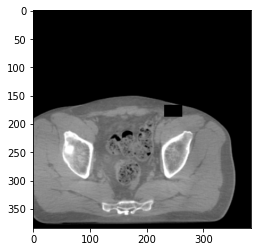

In [29]:
plt.imshow(x.squeeze(), 'gray'),

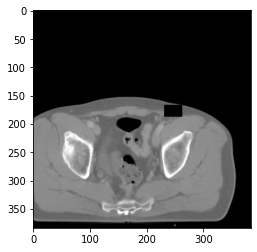

In [30]:
plt.imshow(y.squeeze(), 'gray')

In [31]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [32]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [33]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)

replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)

In [34]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)

In [35]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)

In [36]:
edge_discriminator

Discriminator(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): LeakyReLU(negative_slope=0.01)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): InstanceNor

In [37]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
tf_dis_optimizer = Optimizer(tf_discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)
edge_dis_optimizer = Optimizer(edge_discriminator.parameters(), name=E_OPTIM_NAME, lr=E_init_lr)

In [38]:
from codes.scheduler import Scheduler
tf_scheduler = Scheduler(tf_dis_optimizer, name=DIS_scheduler, T_0=10, T_mult=2)
edge_scheduler = Scheduler(edge_dis_optimizer, name=E_scheduler, T_0=10, T_mult=2)

In [39]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet34"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [40]:
wandb.watch(model)
wandb.watch(tf_discriminator)
wandb.watch(edge_discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_air, loss_bone,loss_tf_gen, loss_tf_dis, tf_lr = train_a2b_epoch(epoch, model, gen_optimizer, 
                                                                                             tf_discriminator, tf_dis_optimizer, tf_scheduler, 
                                                                                             edge_discriminator, edge_dis_optimizer, edge_scheduler,
                                                                                             trainloader, device)
        
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, \
            score_air_train, score_bone_train, score_cont_train, score_tf_acc_train = eval_epoch(model, tf_discriminator, edge_discriminator, trainloader, device)
        
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
            score_air_test, score_bone_test, score_cont_test, score_tf_acc_test = eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

        wandb.log({
            "lr scheduler tf": tf_lr,
            
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_tf_gen,
            "loss dis": loss_tf_dis,
            
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_tf_acc_train,
            
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_tf_acc_test,
        })
        
        
        if score_air_test +  score_bone_test + score_snr_test>= max_score:
            max_score = score_air_test +  score_bone_test + score_snr_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "tf_discriminator": tf_discriminator.state_dict(),
                "tf_dis_optimizer": tf_dis_optimizer.state_dict(),
                "tf_scheduler": tf_scheduler.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

336it [00:39,  8.53it/s]
336it [01:52,  2.98it/s]
336it [00:29, 11.47it/s]
48it [00:04, 11.05it/s]
336it [00:38,  8.78it/s]
336it [01:53,  2.96it/s]
336it [00:29, 11.43it/s]
48it [00:04, 11.03it/s]
336it [00:38,  8.73it/s]
336it [01:53,  2.96it/s]
336it [00:29, 11.44it/s]
48it [00:04, 10.99it/s]
336it [00:38,  8.75it/s]
336it [01:53,  2.95it/s]
336it [00:29, 11.41it/s]
48it [00:04, 11.03it/s]
336it [00:38,  8.73it/s]
336it [01:53,  2.96it/s]
336it [00:29, 11.37it/s]
48it [00:04, 10.97it/s]
336it [00:38,  8.72it/s]
336it [01:53,  2.95it/s]
336it [00:29, 11.47it/s]
48it [00:04, 10.98it/s]
336it [00:38,  8.74it/s]
336it [01:53,  2.96it/s]
336it [00:29, 11.39it/s]
48it [00:04, 11.00it/s]
336it [00:38,  8.75it/s]
336it [01:54,  2.95it/s]
336it [00:29, 11.38it/s]
48it [00:04, 11.03it/s]
336it [00:38,  8.71it/s]
336it [01:53,  2.95it/s]
336it [00:29, 11.39it/s]
48it [00:04, 10.94it/s]
336it [00:38,  8.73it/s]
336it [01:54,  2.95it/s]
336it [00:29, 11.40it/s]
48it [00:04, 10.98it/s]
336it [00:

In [41]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [42]:
model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [43]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.8892403841018677
psnr score = 25.6644344329834
snr score = 15.727372169494629
mae error = 0.016956226900219917
air dice score = 0.997954648258503
bone dice score = 0.9587357330998136
contour dice score = 0.6288782954216003


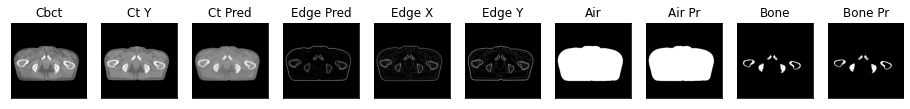

1it [00:00,  1.93it/s]

ssim score = 0.8900846838951111
psnr score = 25.59199333190918
snr score = 15.70246696472168
mae error = 0.017247222363948822
air dice score = 0.9980640533024125
bone dice score = 0.9618030147817679
contour dice score = 0.576900064945221


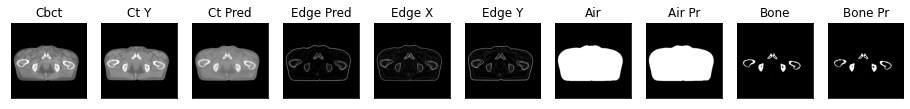

2it [00:00,  2.03it/s]

ssim score = 0.8887296319007874
psnr score = 25.41846466064453
snr score = 15.691834449768066
mae error = 0.018274901434779167
air dice score = 0.9977984392506852
bone dice score = 0.9394053443741136
contour dice score = 0.5876720547676086


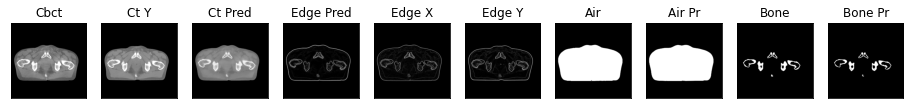

3it [00:01,  2.10it/s]

ssim score = 0.8870427012443542
psnr score = 25.504592895507812
snr score = 15.867218017578125
mae error = 0.018499797210097313
air dice score = 0.9978136694898584
bone dice score = 0.9141803939648175
contour dice score = 0.6826634407043457


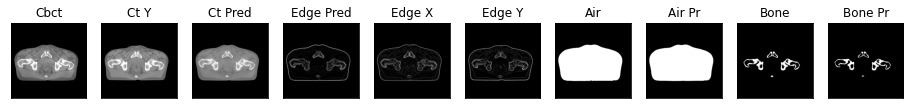

4it [00:01,  2.19it/s]

ssim score = 0.8862631916999817
psnr score = 25.5250244140625
snr score = 15.927947998046875
mae error = 0.018760668113827705
air dice score = 0.9973035705466963
bone dice score = 0.8843899840182804
contour dice score = 0.7319711446762085


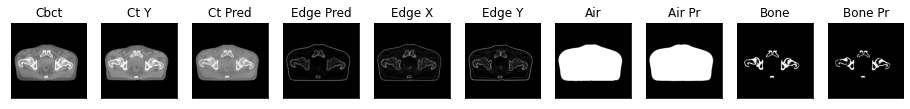

5it [00:02,  2.26it/s]

ssim score = 0.8810911178588867
psnr score = 25.300525665283203
snr score = 15.839982986450195
mae error = 0.019771600142121315
air dice score = 0.9973626809438852
bone dice score = 0.852519992562279
contour dice score = 0.7896323204040527


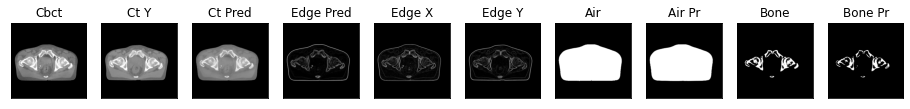

6it [00:02,  2.34it/s]

ssim score = 0.8777713179588318
psnr score = 25.14328956604004
snr score = 15.658692359924316
mae error = 0.019813433289527893
air dice score = 0.9969968771513265
bone dice score = 0.8674889867853085
contour dice score = 0.7750906944274902


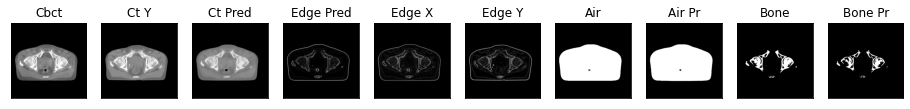

7it [00:03,  2.33it/s]

ssim score = 0.8820603489875793
psnr score = 25.684412002563477
snr score = 16.0142765045166
mae error = 0.018253382295370102
air dice score = 0.9972606588466699
bone dice score = 0.9020906252965463
contour dice score = 0.7657766938209534


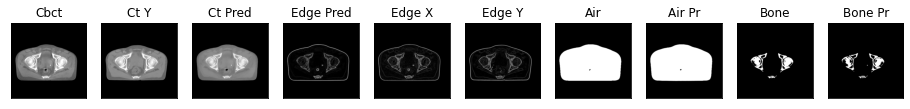

8it [00:03,  2.38it/s]

ssim score = 0.8859965205192566
psnr score = 26.182231903076172
snr score = 16.417543411254883
mae error = 0.01744849793612957
air dice score = 0.9982528605621162
bone dice score = 0.9251056976049415
contour dice score = 0.7449787259101868


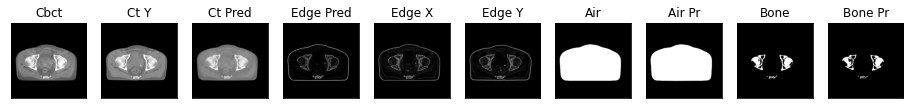

9it [00:04,  1.98it/s]

ssim score = 0.8900895714759827
psnr score = 26.196571350097656
snr score = 16.41659927368164
mae error = 0.01722947508096695
air dice score = 0.9979570056411059
bone dice score = 0.9189644285422125
contour dice score = 0.7053081393241882


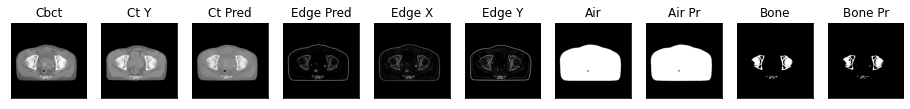

10it [00:04,  2.08it/s]

ssim score = 0.896092414855957
psnr score = 26.5964298248291
snr score = 16.848726272583008
mae error = 0.016822168603539467
air dice score = 0.998077513038145
bone dice score = 0.9420593753455241
contour dice score = 0.702504575252533


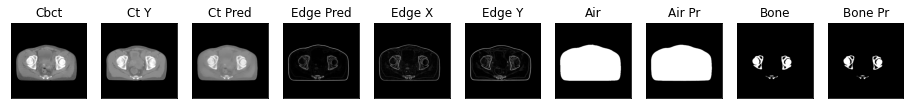

11it [00:04,  2.14it/s]

ssim score = 0.8942221999168396
psnr score = 25.534881591796875
snr score = 15.81088924407959
mae error = 0.01830386556684971
air dice score = 0.9975501597047812
bone dice score = 0.9379922351643041
contour dice score = 0.7299448847770691


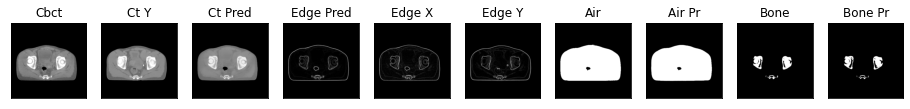

12it [00:05,  2.25it/s]

ssim score = 0.8991678953170776
psnr score = 24.893091201782227
snr score = 15.137175559997559
mae error = 0.01897050440311432
air dice score = 0.9974398896540221
bone dice score = 0.9454931571502418
contour dice score = 0.7610294222831726


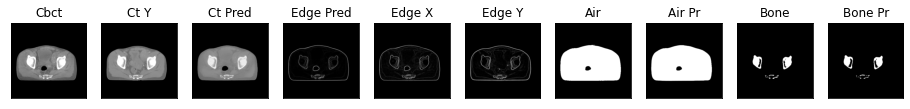

13it [00:05,  2.30it/s]

ssim score = 0.8977711200714111
psnr score = 24.861385345458984
snr score = 14.963512420654297
mae error = 0.0181625597178936
air dice score = 0.9973971231361005
bone dice score = 0.94328207713709
contour dice score = 0.760493814945221


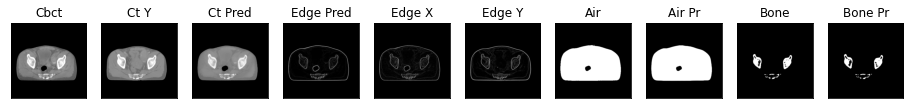

14it [00:06,  2.37it/s]

ssim score = 0.8950918912887573
psnr score = 24.800596237182617
snr score = 14.817062377929688
mae error = 0.018229488283395767
air dice score = 0.9964739890513692
bone dice score = 0.9397622545754005
contour dice score = 0.7320987582206726


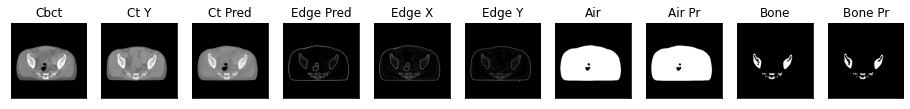

15it [00:06,  2.38it/s]

ssim score = 0.8893184661865234
psnr score = 24.50008773803711
snr score = 14.5400390625
mae error = 0.019466158002614975
air dice score = 0.9957933524318727
bone dice score = 0.9364955935726219
contour dice score = 0.7651847004890442


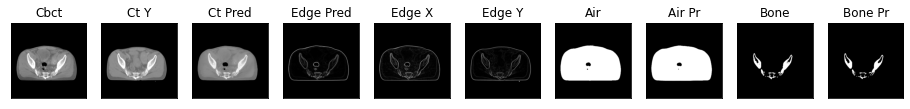

16it [00:07,  2.43it/s]

ssim score = 0.885306715965271
psnr score = 23.703689575195312
snr score = 13.741094589233398
mae error = 0.020960574969649315
air dice score = 0.9952932306532444
bone dice score = 0.9379683085623637
contour dice score = 0.7479572892189026


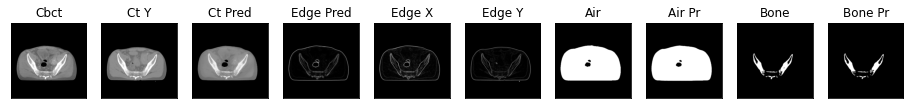

17it [00:07,  2.39it/s]

ssim score = 0.8773166537284851
psnr score = 23.127277374267578
snr score = 13.0629243850708
mae error = 0.022016577422618866
air dice score = 0.9942976537674724
bone dice score = 0.9176264396605205
contour dice score = 0.6955982446670532


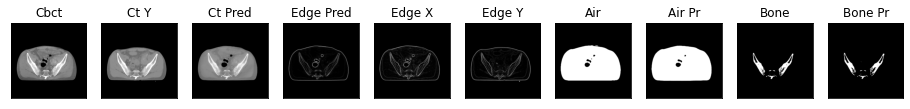

18it [00:08,  2.04it/s]

ssim score = 0.8743457794189453
psnr score = 22.863588333129883
snr score = 12.748555183410645
mae error = 0.022556597366929054
air dice score = 0.9933933012676607
bone dice score = 0.9155588380118715
contour dice score = 0.6564691066741943


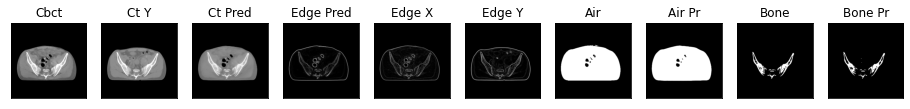

19it [00:08,  2.13it/s]

ssim score = 0.8779405951499939
psnr score = 22.935400009155273
snr score = 12.80805492401123
mae error = 0.02247321605682373
air dice score = 0.9941424994208751
bone dice score = 0.921162879269758
contour dice score = 0.6886493563652039


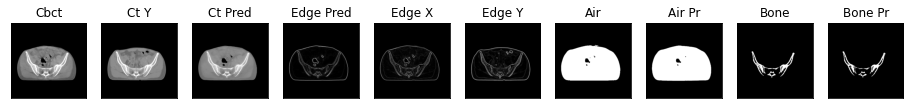

20it [00:08,  2.21it/s]

ssim score = 0.8760365843772888
psnr score = 22.857643127441406
snr score = 12.665451049804688
mae error = 0.022344328463077545
air dice score = 0.9955107997014676
bone dice score = 0.919769989048196
contour dice score = 0.6862996220588684


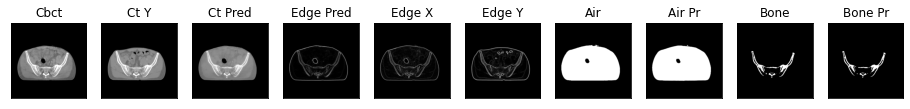

21it [00:09,  2.30it/s]

ssim score = 0.8730787634849548
psnr score = 22.904958724975586
snr score = 12.653339385986328
mae error = 0.02186797745525837
air dice score = 0.9947751990133482
bone dice score = 0.9214603260147991
contour dice score = 0.6387096643447876


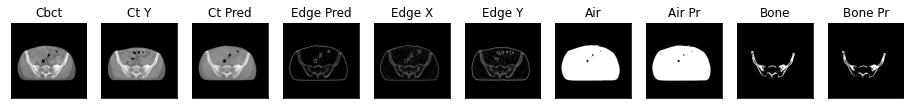

22it [00:09,  2.39it/s]

ssim score = 0.877608597278595
psnr score = 23.011028289794922
snr score = 12.725981712341309
mae error = 0.021668514236807823
air dice score = 0.9939513388609557
bone dice score = 0.9175443103015984
contour dice score = 0.6035042405128479


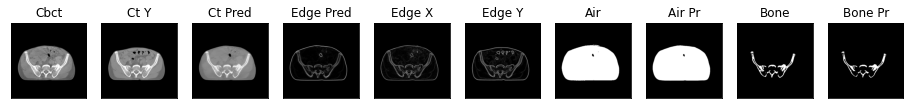

23it [00:10,  2.39it/s]

ssim score = 0.877118706703186
psnr score = 22.933103561401367
snr score = 12.599491119384766
mae error = 0.02204064466059208
air dice score = 0.9939097546762413
bone dice score = 0.9131896873843169
contour dice score = 0.592010498046875


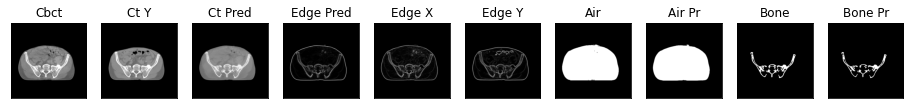

24it [00:10,  2.46it/s]

ssim score = 0.8763009309768677
psnr score = 22.769315719604492
snr score = 12.338701248168945
mae error = 0.022196153178811073
air dice score = 0.9936115201335741
bone dice score = 0.9102241399986788
contour dice score = 0.580428957939148


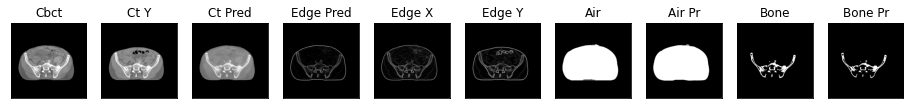

25it [00:10,  2.42it/s]

ssim score = 0.879866361618042
psnr score = 22.976268768310547
snr score = 12.462922096252441
mae error = 0.021688682958483696
air dice score = 0.9943820224719168
bone dice score = 0.8952426717936659
contour dice score = 0.5509383082389832


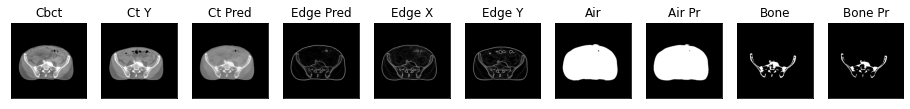

26it [00:11,  2.42it/s]

ssim score = 0.8793744444847107
psnr score = 23.03224754333496
snr score = 12.427712440490723
mae error = 0.021853646263480186
air dice score = 0.9930245771830014
bone dice score = 0.9126372342920738
contour dice score = 0.56611567735672


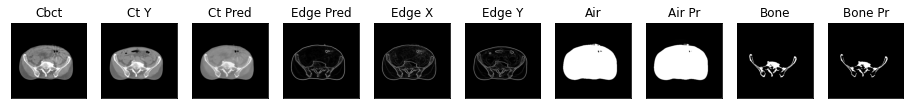

27it [00:11,  2.40it/s]

ssim score = 0.8780339360237122
psnr score = 22.806472778320312
snr score = 12.160833358764648
mae error = 0.022215519100427628
air dice score = 0.9926730052930888
bone dice score = 0.913898455728098
contour dice score = 0.5331452488899231


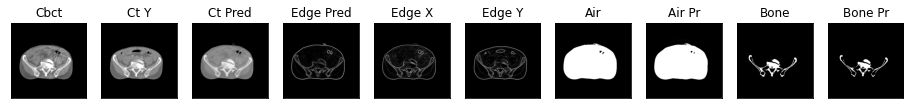

28it [00:12,  2.08it/s]

ssim score = 0.8643688559532166
psnr score = 24.04381561279297
snr score = 15.415972709655762
mae error = 0.022179368883371353
air dice score = 0.9959857767645881
bone dice score = 0.9584352078252312
contour dice score = 0.3415672779083252


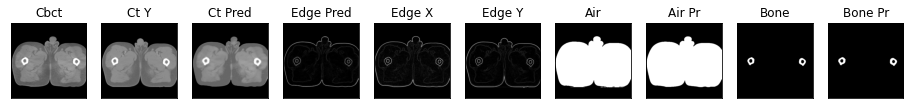

29it [00:12,  2.17it/s]

ssim score = 0.8726274371147156
psnr score = 24.813936233520508
snr score = 16.22534942626953
mae error = 0.020539335906505585
air dice score = 0.9951643388399353
bone dice score = 0.9627507163334456
contour dice score = 0.3060016930103302


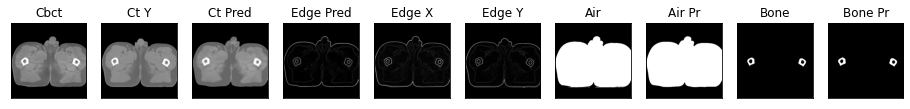

30it [00:13,  2.26it/s]

ssim score = 0.8815938830375671
psnr score = 25.66216278076172
snr score = 17.161027908325195
mae error = 0.01884612813591957
air dice score = 0.9952280248410894
bone dice score = 0.9678595851386401
contour dice score = 0.2980427145957947


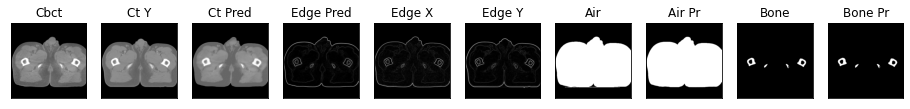

31it [00:13,  2.32it/s]

ssim score = 0.8891634345054626
psnr score = 26.19917106628418
snr score = 17.86058807373047
mae error = 0.019034337252378464
air dice score = 0.9962434715170339
bone dice score = 0.9714376894850576
contour dice score = 0.30677106976509094


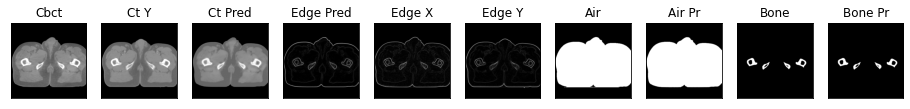

32it [00:13,  2.41it/s]

ssim score = 0.890266478061676
psnr score = 26.381074905395508
snr score = 18.170639038085938
mae error = 0.019701624289155006
air dice score = 0.9968895425939787
bone dice score = 0.9624841927783829
contour dice score = 0.27534884214401245


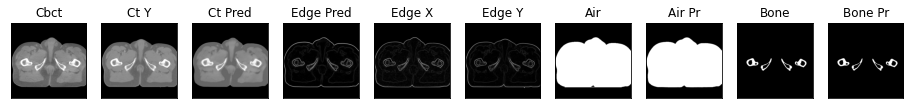

33it [00:14,  2.40it/s]

ssim score = 0.8921253085136414
psnr score = 26.684574127197266
snr score = 18.577377319335938
mae error = 0.020132580772042274
air dice score = 0.9973584361942286
bone dice score = 0.9525229927920392
contour dice score = 0.29036760330200195


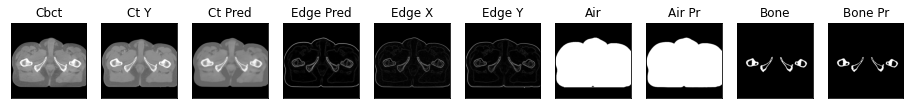

34it [00:14,  2.45it/s]

ssim score = 0.8939322233200073
psnr score = 26.925830841064453
snr score = 18.88573455810547
mae error = 0.020642071962356567
air dice score = 0.9972130853417874
bone dice score = 0.9312070771745872
contour dice score = 0.26443204283714294


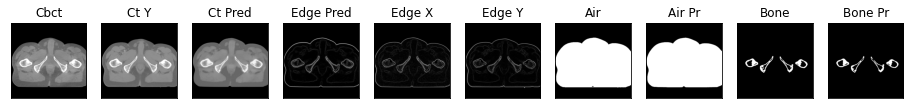

35it [00:15,  2.43it/s]

ssim score = 0.8922246098518372
psnr score = 26.958627700805664
snr score = 18.908639907836914
mae error = 0.020457491278648376
air dice score = 0.9974180545368911
bone dice score = 0.9372944529715271
contour dice score = 0.2875695824623108


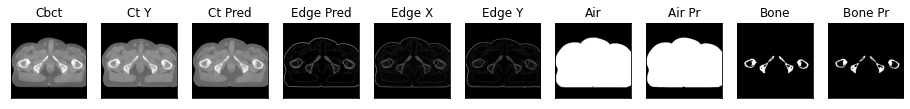

36it [00:15,  2.38it/s]

ssim score = 0.895685613155365
psnr score = 27.190040588378906
snr score = 19.126388549804688
mae error = 0.020040025934576988
air dice score = 0.9974296424109017
bone dice score = 0.9476850359872415
contour dice score = 0.26252320408821106


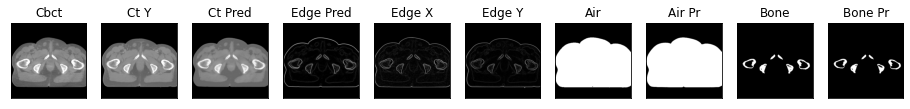

37it [00:16,  2.41it/s]

ssim score = 0.8975164294242859
psnr score = 27.461536407470703
snr score = 19.40988540649414
mae error = 0.019900865852832794
air dice score = 0.997551845029415
bone dice score = 0.9415650985312499
contour dice score = 0.282527893781662


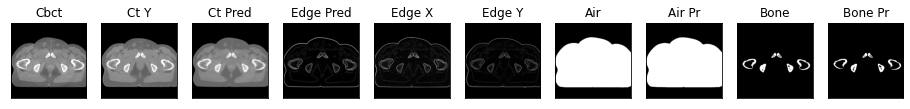

38it [00:16,  2.07it/s]

ssim score = 0.8977550268173218
psnr score = 27.351242065429688
snr score = 19.338674545288086
mae error = 0.020488420501351357
air dice score = 0.9975886154138568
bone dice score = 0.937793427230777
contour dice score = 0.3030303120613098


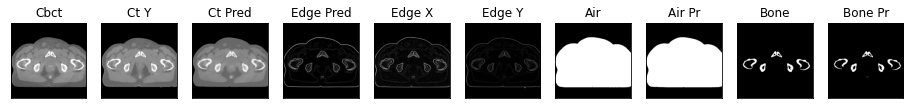

39it [00:17,  2.16it/s]

ssim score = 0.8977944850921631
psnr score = 26.959274291992188
snr score = 19.087997436523438
mae error = 0.022839972749352455
air dice score = 0.997528693296582
bone dice score = 0.9111386650143507
contour dice score = 0.33193081617355347


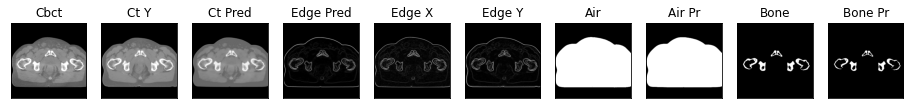

40it [00:17,  2.28it/s]

ssim score = 0.8946803212165833
psnr score = 26.590068817138672
snr score = 18.813478469848633
mae error = 0.0249479953199625
air dice score = 0.9975375904073102
bone dice score = 0.8822187116036316
contour dice score = 0.32209739089012146


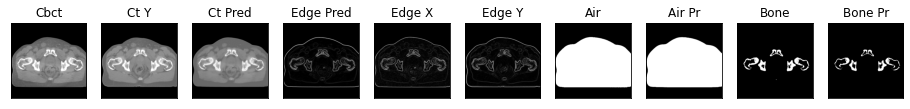

41it [00:17,  2.29it/s]

ssim score = 0.8835152983665466
psnr score = 25.822078704833984
snr score = 18.011442184448242
mae error = 0.025537172332406044
air dice score = 0.997547425393398
bone dice score = 0.8322540583710436
contour dice score = 0.3359924852848053


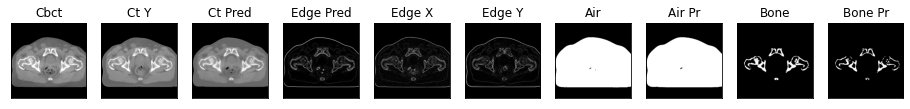

42it [00:18,  2.38it/s]

ssim score = 0.8820755481719971
psnr score = 24.79183006286621
snr score = 17.05337905883789
mae error = 0.027484072372317314
air dice score = 0.997160506426382
bone dice score = 0.7622539252429883
contour dice score = 0.3146490752696991


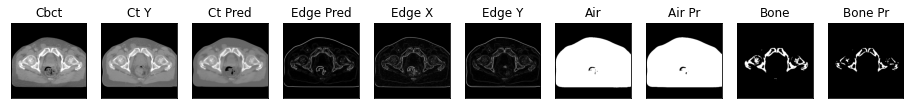

43it [00:18,  2.38it/s]

ssim score = 0.8825151324272156
psnr score = 25.15613555908203
snr score = 17.281591415405273
mae error = 0.025638695806264877
air dice score = 0.9974457215836542
bone dice score = 0.8147489126155126
contour dice score = 0.36054742336273193


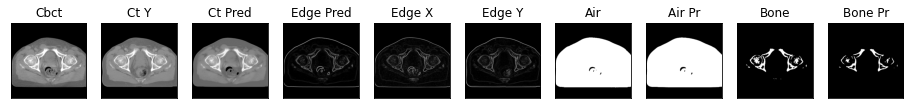

44it [00:19,  2.43it/s]

ssim score = 0.8852306008338928
psnr score = 25.65168571472168
snr score = 17.59857749938965
mae error = 0.0227094367146492
air dice score = 0.9975894588667451
bone dice score = 0.858452355576013
contour dice score = 0.40568721294403076


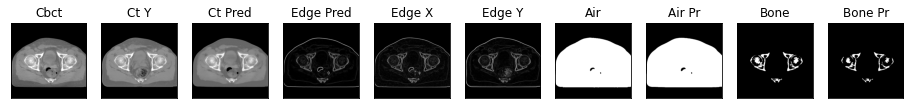

45it [00:19,  2.39it/s]

ssim score = 0.8836076855659485
psnr score = 25.984012603759766
snr score = 17.840316772460938
mae error = 0.021958183497190475
air dice score = 0.9978341883651161
bone dice score = 0.8725038402472821
contour dice score = 0.4093288779258728


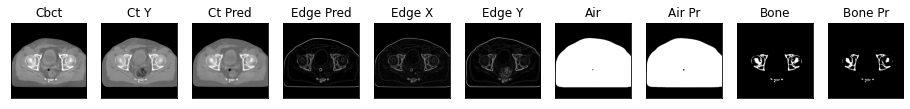

46it [00:20,  2.36it/s]

ssim score = 0.883601725101471
psnr score = 25.98228645324707
snr score = 17.854284286499023
mae error = 0.02186903916299343
air dice score = 0.9980252164666578
bone dice score = 0.8784305081022987
contour dice score = 0.44105011224746704


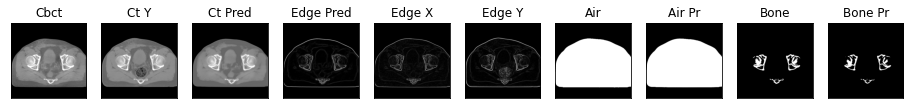

47it [00:20,  2.43it/s]

ssim score = 0.8722428679466248
psnr score = 25.63920783996582
snr score = 17.521240234375
mae error = 0.023044835776090622
air dice score = 0.9978867389817271
bone dice score = 0.8605569620267286
contour dice score = 0.42215853929519653


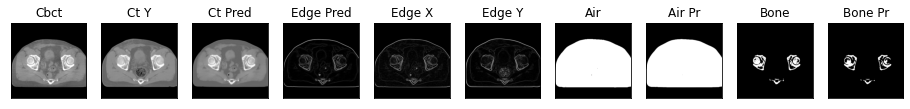

48it [00:21,  2.09it/s]

ssim score = 0.8794059157371521
psnr score = 25.776813507080078
snr score = 17.72043228149414
mae error = 0.023535609245300293
air dice score = 0.9978122452981671
bone dice score = 0.8684731012671235
contour dice score = 0.44773268699645996


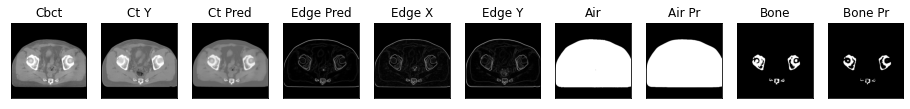

49it [00:21,  2.20it/s]

ssim score = 0.881608784198761
psnr score = 26.1623592376709
snr score = 18.176063537597656
mae error = 0.02373652718961239
air dice score = 0.9975861285309795
bone dice score = 0.9226932668336317
contour dice score = 0.44497379660606384


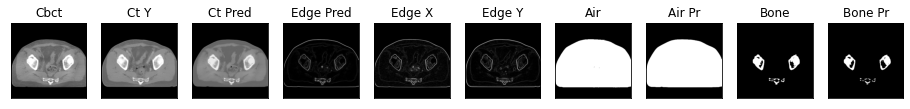

50it [00:21,  2.31it/s]

ssim score = 0.8890889883041382
psnr score = 26.255935668945312
snr score = 18.150535583496094
mae error = 0.02210278809070587
air dice score = 0.9976660770440265
bone dice score = 0.9060360920980498
contour dice score = 0.45281219482421875


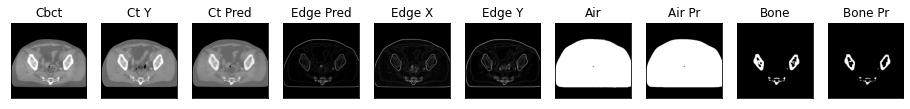

51it [00:22,  2.32it/s]

ssim score = 0.8829452991485596
psnr score = 25.434940338134766
snr score = 17.411165237426758
mae error = 0.024667249992489815
air dice score = 0.9973728147711665
bone dice score = 0.9007175946961512
contour dice score = 0.4178246259689331


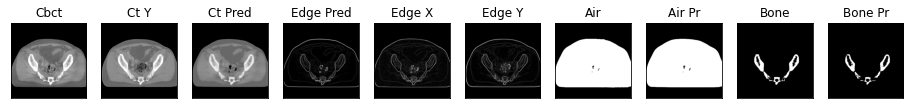

52it [00:22,  2.40it/s]

ssim score = 0.8822620511054993
psnr score = 25.334190368652344
snr score = 17.39056396484375
mae error = 0.02564171701669693
air dice score = 0.9967833838801601
bone dice score = 0.8694225209043571
contour dice score = 0.3381364047527313


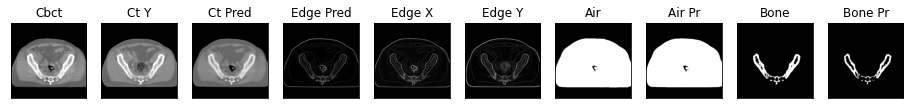

53it [00:23,  2.40it/s]

ssim score = 0.8647673726081848
psnr score = 24.762861251831055
snr score = 16.840789794921875
mae error = 0.027057776227593422
air dice score = 0.9969990893366845
bone dice score = 0.846246102184007
contour dice score = 0.31918996572494507


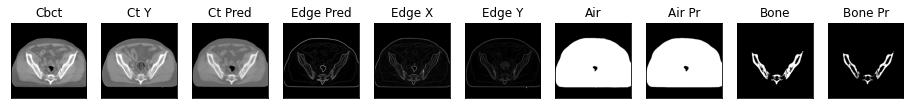

54it [00:23,  2.37it/s]

ssim score = 0.8650741577148438
psnr score = 25.4641170501709
snr score = 17.554582595825195
mae error = 0.02610684372484684
air dice score = 0.9967259631125197
bone dice score = 0.8535699878995274
contour dice score = 0.2338787317276001


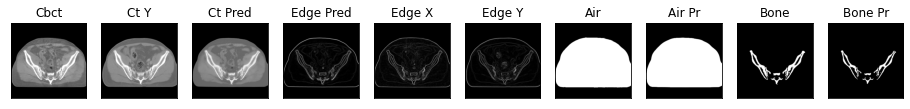

55it [00:23,  2.36it/s]

ssim score = 0.8130251169204712
psnr score = 21.00234603881836
snr score = 10.882554054260254
mae error = 0.032047372311353683
air dice score = 0.997322193658957
bone dice score = 0.9340518347463677
contour dice score = 0.5948037505149841


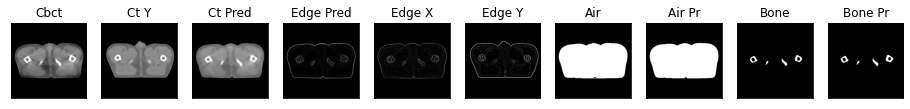

56it [00:24,  2.38it/s]

ssim score = 0.8039341568946838
psnr score = 20.781951904296875
snr score = 10.875140190124512
mae error = 0.03306543081998825
air dice score = 0.9977021691877765
bone dice score = 0.9260620915047781
contour dice score = 0.6307692527770996


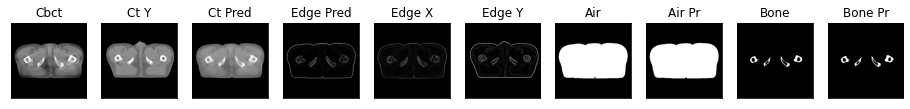

57it [00:24,  2.46it/s]

ssim score = 0.8002525568008423
psnr score = 20.814313888549805
snr score = 11.038639068603516
mae error = 0.03338581323623657
air dice score = 0.9980848829307486
bone dice score = 0.9144385026754309
contour dice score = 0.6165661215782166


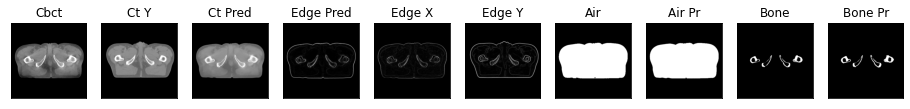

58it [00:25,  2.10it/s]

ssim score = 0.80614173412323
psnr score = 21.188243865966797
snr score = 11.482975006103516
mae error = 0.03188610449433327
air dice score = 0.9973548925699747
bone dice score = 0.9107373868063068
contour dice score = 0.5134099721908569


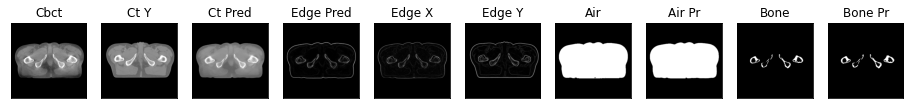

59it [00:25,  2.17it/s]

ssim score = 0.8084830641746521
psnr score = 21.318851470947266
snr score = 11.661148071289062
mae error = 0.03147612512111664
air dice score = 0.9971453090246789
bone dice score = 0.9195319531967681
contour dice score = 0.5384196043014526


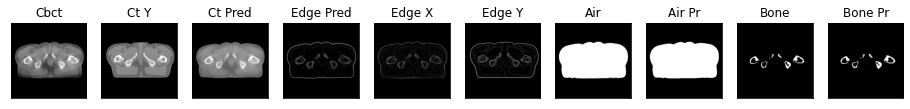

60it [00:26,  2.28it/s]

ssim score = 0.8093795776367188
psnr score = 21.475929260253906
snr score = 11.823841094970703
mae error = 0.030859556049108505
air dice score = 0.9967799080223079
bone dice score = 0.9336907953541789
contour dice score = 0.5095541477203369


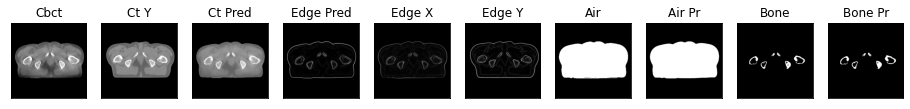

61it [00:26,  2.32it/s]

ssim score = 0.8097695112228394
psnr score = 21.50851058959961
snr score = 11.849919319152832
mae error = 0.030814873054623604
air dice score = 0.9962754755730404
bone dice score = 0.9229371137782091
contour dice score = 0.5305688381195068


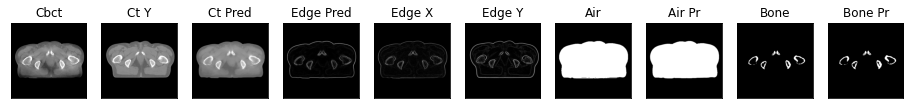

62it [00:26,  2.39it/s]

ssim score = 0.8076857924461365
psnr score = 21.335311889648438
snr score = 11.69083023071289
mae error = 0.03130517527461052
air dice score = 0.9967048785140765
bone dice score = 0.9369045479069404
contour dice score = 0.5191082954406738


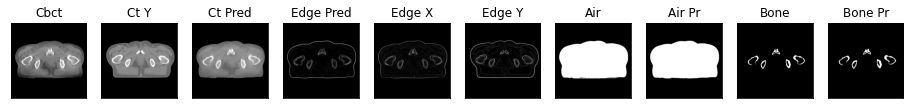

63it [00:27,  2.37it/s]

ssim score = 0.8058096170425415
psnr score = 21.22347068786621
snr score = 11.636999130249023
mae error = 0.03189863637089729
air dice score = 0.9966820005024676
bone dice score = 0.9332483670553887
contour dice score = 0.5638014078140259


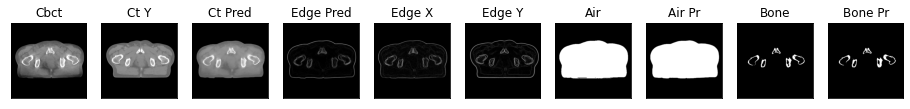

64it [00:27,  2.35it/s]

ssim score = 0.7980268001556396
psnr score = 21.061569213867188
snr score = 11.573654174804688
mae error = 0.033076245337724686
air dice score = 0.9963024396986693
bone dice score = 0.9204236006063476
contour dice score = 0.507651686668396


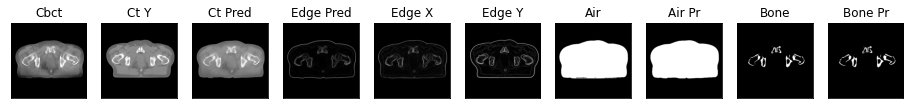

65it [00:28,  2.42it/s]

ssim score = 0.7873373627662659
psnr score = 20.931896209716797
snr score = 11.479812622070312
mae error = 0.034342698752880096
air dice score = 0.99646460291455
bone dice score = 0.9187425860035774
contour dice score = 0.49005910754203796


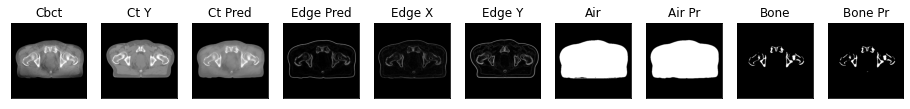

66it [00:28,  2.42it/s]

ssim score = 0.7762407660484314
psnr score = 20.778919219970703
snr score = 11.359538078308105
mae error = 0.035318732261657715
air dice score = 0.9969423701368638
bone dice score = 0.8906357743774564
contour dice score = 0.5845824480056763


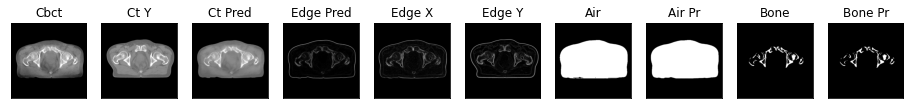

67it [00:28,  2.47it/s]

ssim score = 0.7768057584762573
psnr score = 20.853351593017578
snr score = 11.550789833068848
mae error = 0.035467080771923065
air dice score = 0.9972873590933775
bone dice score = 0.9211037699194053
contour dice score = 0.6315234303474426


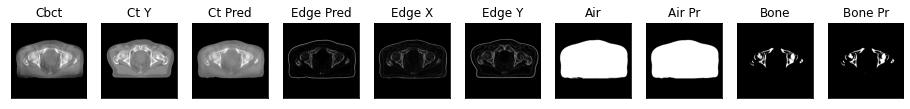

68it [00:29,  2.06it/s]

ssim score = 0.77951979637146
psnr score = 20.89032745361328
snr score = 11.571778297424316
mae error = 0.03524525463581085
air dice score = 0.9979077516509838
bone dice score = 0.9096702687737646
contour dice score = 0.6028291583061218


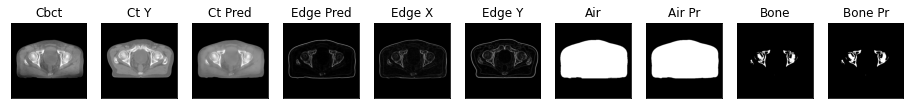

69it [00:30,  2.15it/s]

ssim score = 0.794314444065094
psnr score = 21.40612030029297
snr score = 11.888410568237305
mae error = 0.03260214999318123
air dice score = 0.997797546328959
bone dice score = 0.9180040852069156
contour dice score = 0.6215780973434448


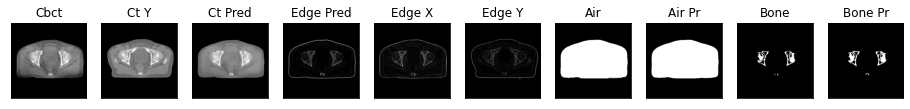

70it [00:30,  2.26it/s]

ssim score = 0.8116921186447144
psnr score = 22.048812866210938
snr score = 12.360706329345703
mae error = 0.03010176308453083
air dice score = 0.9976291104009917
bone dice score = 0.9400355142748253
contour dice score = 0.5712748765945435


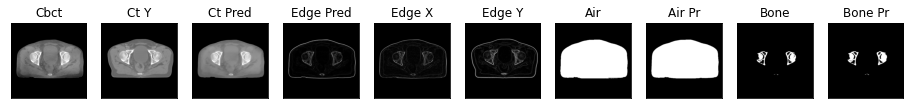

71it [00:30,  2.27it/s]

ssim score = 0.8195079565048218
psnr score = 22.439048767089844
snr score = 12.765110969543457
mae error = 0.028846127912402153
air dice score = 0.9973932430114926
bone dice score = 0.9421059448265496
contour dice score = 0.561965823173523


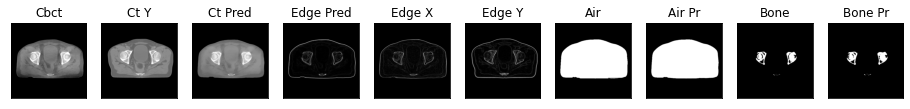

72it [00:31,  2.30it/s]

ssim score = 0.8249436020851135
psnr score = 22.714092254638672
snr score = 13.12198543548584
mae error = 0.02789527177810669
air dice score = 0.997742354792367
bone dice score = 0.9541309012881688
contour dice score = 0.5979381203651428


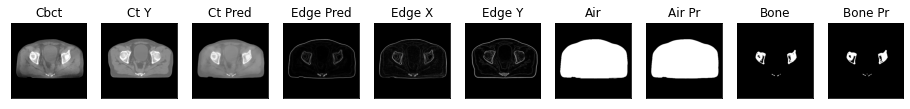

73it [00:31,  2.39it/s]

ssim score = 0.8224809169769287
psnr score = 22.658998489379883
snr score = 13.159064292907715
mae error = 0.028812196105718613
air dice score = 0.9976118588267424
bone dice score = 0.9351217378636081
contour dice score = 0.5646670460700989


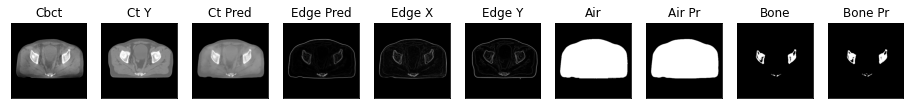

74it [00:32,  2.40it/s]

ssim score = 0.8176938891410828
psnr score = 22.925006866455078
snr score = 13.361645698547363
mae error = 0.027659446001052856
air dice score = 0.9977225989564764
bone dice score = 0.9525347110114217
contour dice score = 0.6219838857650757


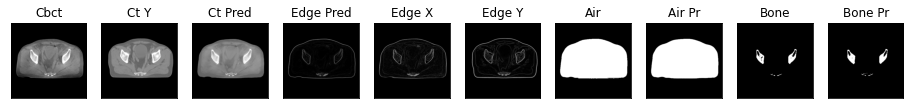

75it [00:32,  2.48it/s]

ssim score = 0.822579562664032
psnr score = 23.074071884155273
snr score = 13.474315643310547
mae error = 0.026615943759679794
air dice score = 0.9972483141677873
bone dice score = 0.9400620048236297
contour dice score = 0.5566790699958801


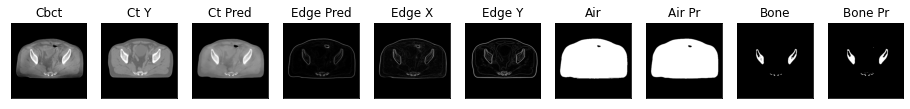

76it [00:32,  2.46it/s]

ssim score = 0.8207741379737854
psnr score = 22.822362899780273
snr score = 13.260353088378906
mae error = 0.02800511009991169
air dice score = 0.9975536830660526
bone dice score = 0.9314676419155435
contour dice score = 0.5609756112098694


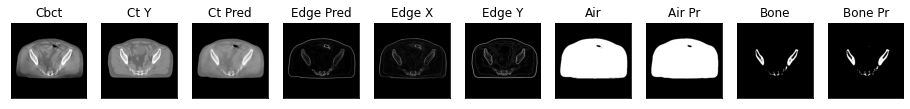

77it [00:33,  2.48it/s]

ssim score = 0.8179374933242798
psnr score = 22.73419189453125
snr score = 13.302684783935547
mae error = 0.028667399659752846
air dice score = 0.9971681987873452
bone dice score = 0.9371952968176485
contour dice score = 0.5715811848640442


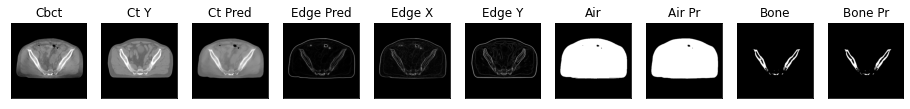

78it [00:33,  2.10it/s]

ssim score = 0.8203789591789246
psnr score = 22.61305046081543
snr score = 13.199295043945312
mae error = 0.029310021549463272
air dice score = 0.9969691019150179
bone dice score = 0.9142149272233785
contour dice score = 0.5692803263664246


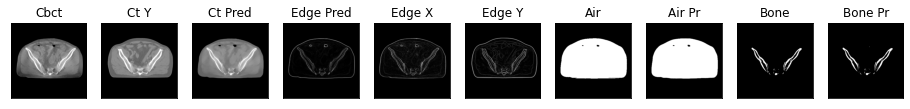

79it [00:34,  2.18it/s]

ssim score = 0.8231106996536255
psnr score = 23.056182861328125
snr score = 13.631158828735352
mae error = 0.027974439784884453
air dice score = 0.9970863469646616
bone dice score = 0.9220475075289052
contour dice score = 0.554295003414154


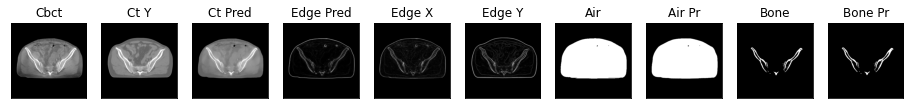

80it [00:34,  2.31it/s]

ssim score = 0.8242683410644531
psnr score = 23.190921783447266
snr score = 13.765157699584961
mae error = 0.027571333572268486
air dice score = 0.9971014492753648
bone dice score = 0.9191516504557622
contour dice score = 0.5596080422401428


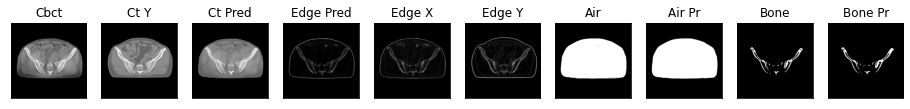

81it [00:35,  2.31it/s]

ssim score = 0.867951512336731
psnr score = 23.693023681640625
snr score = 14.127158164978027
mae error = 0.022220147773623466
air dice score = 0.9962045704626308
bone dice score = 0.8976597974188733
contour dice score = 0.3496280610561371


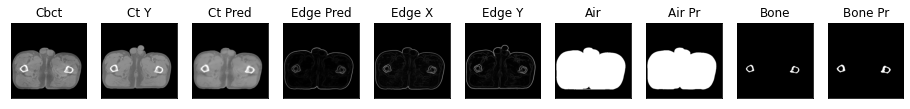

82it [00:35,  2.33it/s]

ssim score = 0.8689482808113098
psnr score = 23.976425170898438
snr score = 14.474954605102539
mae error = 0.021450651809573174
air dice score = 0.9957046852215846
bone dice score = 0.8965075296412526
contour dice score = 0.3291272222995758


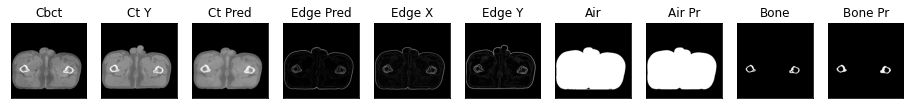

83it [00:35,  2.43it/s]

ssim score = 0.8761935234069824
psnr score = 25.480365753173828
snr score = 16.11810302734375
mae error = 0.018696226179599762
air dice score = 0.9963185763072999
bone dice score = 0.9289991445695253
contour dice score = 0.3331640362739563


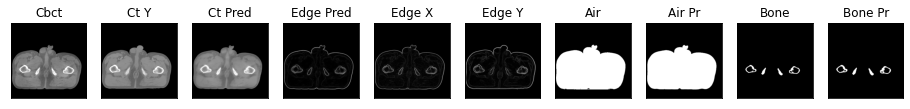

84it [00:36,  2.41it/s]

ssim score = 0.8775379061698914
psnr score = 25.630516052246094
snr score = 16.389747619628906
mae error = 0.01850959286093712
air dice score = 0.9968983307096456
bone dice score = 0.919259711207662
contour dice score = 0.346707820892334


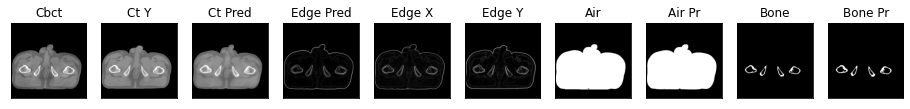

85it [00:36,  2.49it/s]

ssim score = 0.8729463219642639
psnr score = 25.486717224121094
snr score = 16.270118713378906
mae error = 0.018731243908405304
air dice score = 0.9969444638816994
bone dice score = 0.9059829059848659
contour dice score = 0.35477179288864136


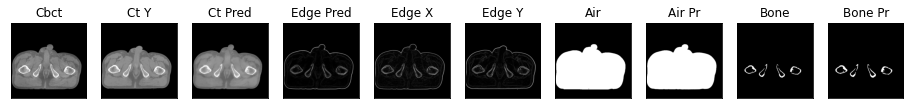

86it [00:37,  2.47it/s]

ssim score = 0.8736913204193115
psnr score = 25.329465866088867
snr score = 16.10847282409668
mae error = 0.018889227882027626
air dice score = 0.9970099177533244
bone dice score = 0.910376457100891
contour dice score = 0.3448275923728943


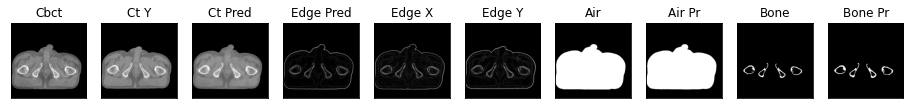

87it [00:37,  2.52it/s]

ssim score = 0.8735951781272888
psnr score = 24.93532943725586
snr score = 15.720588684082031
mae error = 0.01956764981150627
air dice score = 0.9967862632159128
bone dice score = 0.9182484495410966
contour dice score = 0.3547368347644806


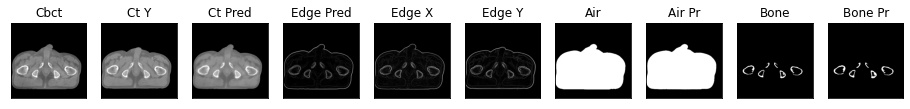

88it [00:38,  2.13it/s]

ssim score = 0.871612548828125
psnr score = 24.715972900390625
snr score = 15.47967529296875
mae error = 0.019607990980148315
air dice score = 0.997250442725326
bone dice score = 0.9092609915826144
contour dice score = 0.3896787762641907


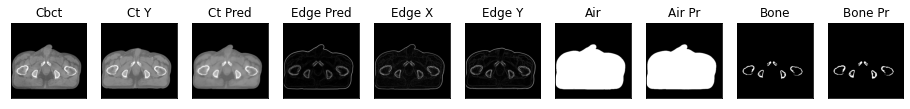

89it [00:38,  2.20it/s]

ssim score = 0.8724412322044373
psnr score = 24.736282348632812
snr score = 15.51689624786377
mae error = 0.019602429121732712
air dice score = 0.9969235082909529
bone dice score = 0.9369272237208099
contour dice score = 0.375


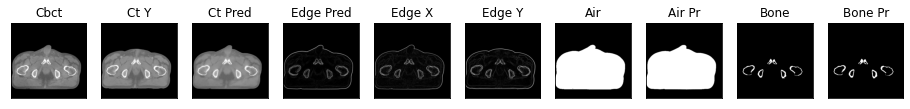

90it [00:38,  2.33it/s]

ssim score = 0.8734716176986694
psnr score = 25.073444366455078
snr score = 15.922653198242188
mae error = 0.019171321764588356
air dice score = 0.9971935804129133
bone dice score = 0.9384087567401012
contour dice score = 0.45973333716392517


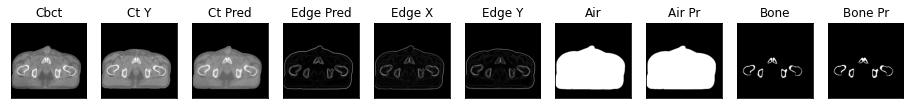

91it [00:39,  2.32it/s]

ssim score = 0.8737514615058899
psnr score = 25.39984893798828
snr score = 16.330415725708008
mae error = 0.01927914097905159
air dice score = 0.9974496402030891
bone dice score = 0.9372896910379735
contour dice score = 0.4997313320636749


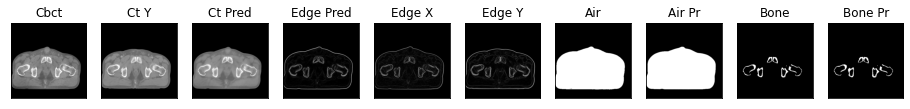

92it [00:39,  2.34it/s]

ssim score = 0.877135694026947
psnr score = 25.769432067871094
snr score = 16.750701904296875
mae error = 0.0192094799131155
air dice score = 0.998015060335866
bone dice score = 0.9271111111121909
contour dice score = 0.543501615524292


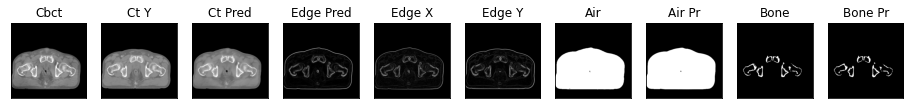

93it [00:40,  2.44it/s]

ssim score = 0.8786805868148804
psnr score = 26.149721145629883
snr score = 17.24725914001465
mae error = 0.019205862656235695
air dice score = 0.9980806748442045
bone dice score = 0.8900911161746855
contour dice score = 0.528240978717804


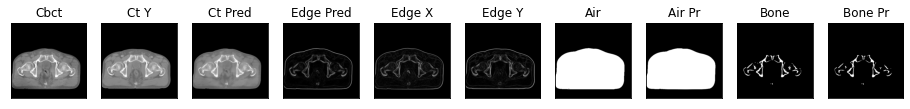

94it [00:40,  2.44it/s]

ssim score = 0.8799207210540771
psnr score = 25.834716796875
snr score = 16.894020080566406
mae error = 0.01881207525730133
air dice score = 0.9982769435996806
bone dice score = 0.8925964546418502
contour dice score = 0.4868066906929016


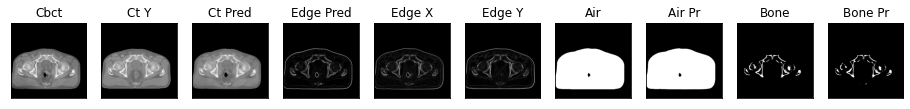

95it [00:40,  2.51it/s]

ssim score = 0.8739884495735168
psnr score = 25.00595474243164
snr score = 15.969590187072754
mae error = 0.01955091580748558
air dice score = 0.9975671046945296
bone dice score = 0.9046321525898552
contour dice score = 0.5094441175460815


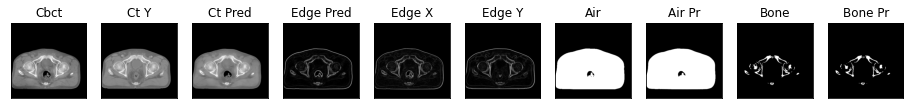

96it [00:41,  2.47it/s]

ssim score = 0.8766975402832031
psnr score = 24.71935272216797
snr score = 15.523225784301758
mae error = 0.01958567276597023
air dice score = 0.9971530191707486
bone dice score = 0.911096897986711
contour dice score = 0.5010822415351868


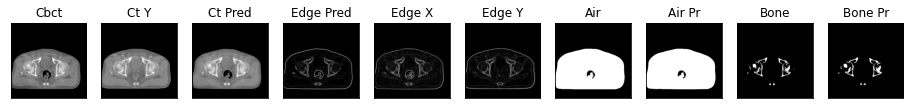

97it [00:41,  2.53it/s]

ssim score = 0.8730545043945312
psnr score = 24.24370765686035
snr score = 14.931156158447266
mae error = 0.0207142923027277
air dice score = 0.9969918560003938
bone dice score = 0.9033091202598336
contour dice score = 0.4328439235687256


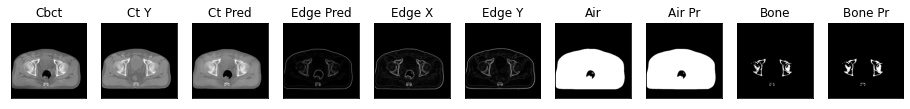

98it [00:42,  2.14it/s]

ssim score = 0.8699642419815063
psnr score = 24.12103271484375
snr score = 14.763387680053711
mae error = 0.021180151030421257
air dice score = 0.9972514173661217
bone dice score = 0.9208193213096787
contour dice score = 0.41743868589401245


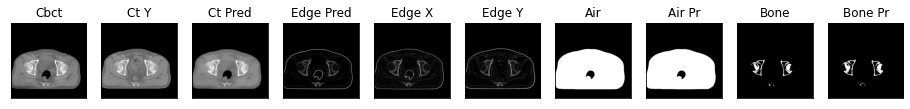

99it [00:42,  2.21it/s]

ssim score = 0.8638007640838623
psnr score = 23.59996795654297
snr score = 14.24899673461914
mae error = 0.02265199087560177
air dice score = 0.9972230894362402
bone dice score = 0.9383679201133037
contour dice score = 0.42841529846191406


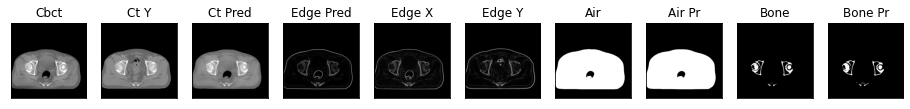

100it [00:43,  2.34it/s]

ssim score = 0.8652297854423523
psnr score = 23.27703285217285
snr score = 13.95616340637207
mae error = 0.023674098774790764
air dice score = 0.9974571459137426
bone dice score = 0.9437462597255574
contour dice score = 0.4573304057121277


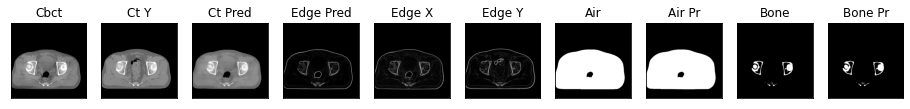

101it [00:43,  2.32it/s]

ssim score = 0.8710452318191528
psnr score = 23.93398094177246
snr score = 14.570526123046875
mae error = 0.021720904856920242
air dice score = 0.9972551404480554
bone dice score = 0.9412552301265061
contour dice score = 0.46356165409088135


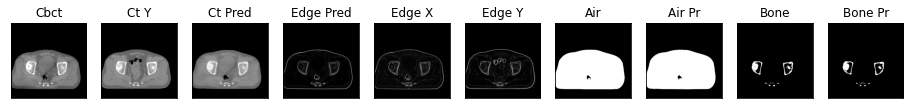

102it [00:44,  2.41it/s]

ssim score = 0.8743454217910767
psnr score = 24.219558715820312
snr score = 14.765900611877441
mae error = 0.020337415859103203
air dice score = 0.9973672265093076
bone dice score = 0.9257911968001857
contour dice score = 0.4679452180862427


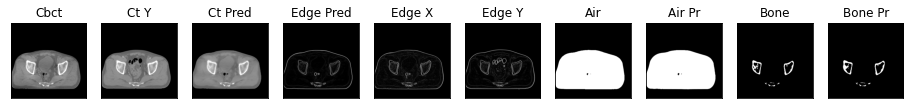

103it [00:44,  2.45it/s]

ssim score = 0.8753053545951843
psnr score = 23.869720458984375
snr score = 14.350336074829102
mae error = 0.020981529727578163
air dice score = 0.9973061558092814
bone dice score = 0.9357384441951195
contour dice score = 0.46787479519844055


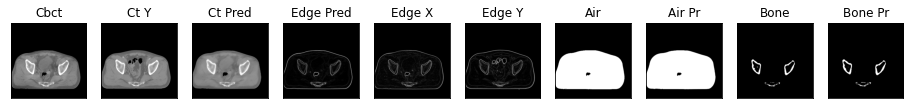

104it [00:44,  2.15it/s]

ssim score = 0.8721471428871155
psnr score = 23.920137405395508
snr score = 14.400452613830566
mae error = 0.021150866523385048
air dice score = 0.9971014979794525
bone dice score = 0.945405677810425
contour dice score = 0.46942147612571716


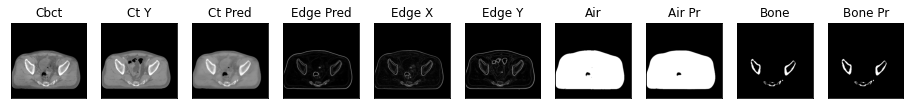

105it [00:45,  2.01it/s]

ssim score = 0.8669401407241821
psnr score = 23.849441528320312
snr score = 14.405923843383789
mae error = 0.02203340455889702
air dice score = 0.9974394193756275
bone dice score = 0.9375354911990696
contour dice score = 0.5425414443016052


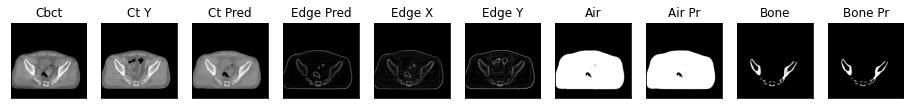

106it [00:46,  1.59it/s]

ssim score = 0.8728649616241455
psnr score = 24.127714157104492
snr score = 14.71977710723877
mae error = 0.02138436958193779
air dice score = 0.9976874567998176
bone dice score = 0.9179926560598668
contour dice score = 0.5900552272796631


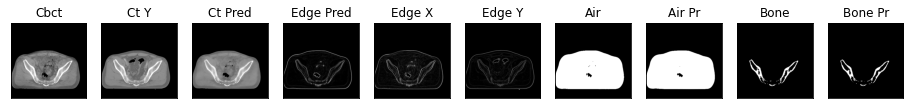

107it [00:47,  1.58it/s]

ssim score = 0.8745176196098328
psnr score = 24.797672271728516
snr score = 15.32803726196289
mae error = 0.020206578075885773
air dice score = 0.9978376894166928
bone dice score = 0.9128041714960486
contour dice score = 0.591564953327179


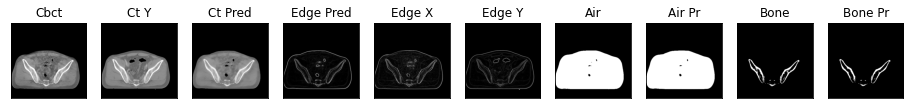

108it [00:47,  1.46it/s]

ssim score = 0.8711115717887878
psnr score = 24.67288589477539
snr score = 15.141986846923828
mae error = 0.020382413640618324
air dice score = 0.9976384287333175
bone dice score = 0.9100449775125931
contour dice score = 0.5198879837989807


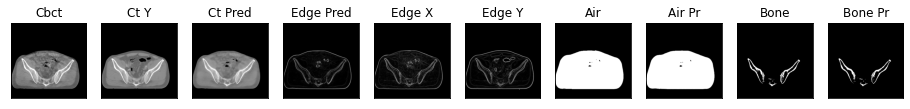

109it [00:48,  1.62it/s]

ssim score = 0.803704559803009
psnr score = 22.504741668701172
snr score = 14.202047348022461
mae error = 0.03120873123407364
air dice score = 0.9966198987155636
bone dice score = 0.9509479386111662
contour dice score = 0.3481709957122803


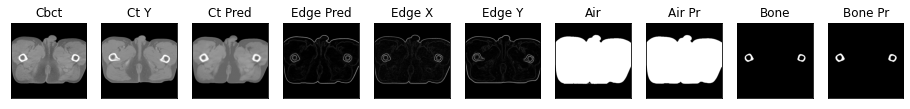

110it [00:48,  1.79it/s]

ssim score = 0.7954820394515991
psnr score = 22.222803115844727
snr score = 14.024399757385254
mae error = 0.032798368483781815
air dice score = 0.9968814662414318
bone dice score = 0.9458074952832082
contour dice score = 0.3795555531978607


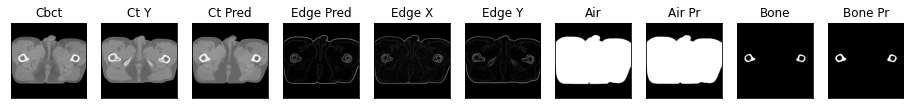

111it [00:49,  1.90it/s]

ssim score = 0.7899743318557739
psnr score = 21.903656005859375
snr score = 13.833209037780762
mae error = 0.035136934369802475
air dice score = 0.9967446233399948
bone dice score = 0.9253667871587207
contour dice score = 0.35273054242134094


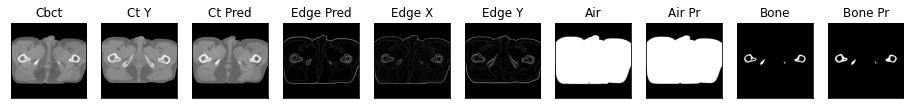

112it [00:49,  2.00it/s]

ssim score = 0.7830582857131958
psnr score = 21.539382934570312
snr score = 13.501225471496582
mae error = 0.03655609115958214
air dice score = 0.9966888387493793
bone dice score = 0.9480434067749417
contour dice score = 0.33363309502601624


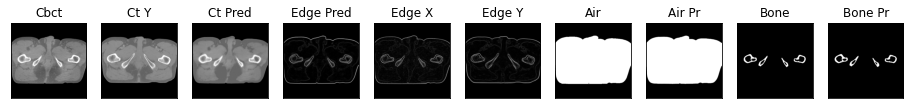

113it [00:50,  2.05it/s]

ssim score = 0.7735459208488464
psnr score = 21.391399383544922
snr score = 13.383480072021484
mae error = 0.037498705089092255
air dice score = 0.9968967512316584
bone dice score = 0.9359844810873588
contour dice score = 0.3580470085144043


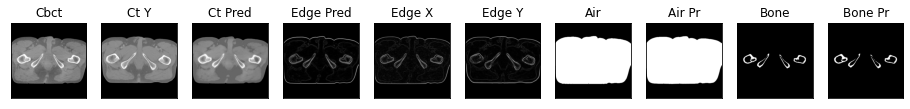

114it [00:50,  2.11it/s]

ssim score = 0.7677545547485352
psnr score = 21.234603881835938
snr score = 13.261102676391602
mae error = 0.03898776322603226
air dice score = 0.9972102666845288
bone dice score = 0.9406109474346316
contour dice score = 0.37375566363334656


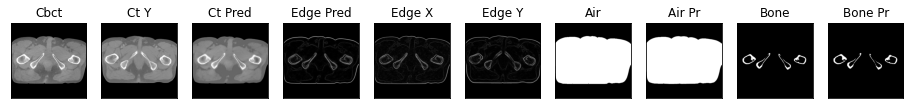

115it [00:51,  2.13it/s]

ssim score = 0.7585904002189636
psnr score = 20.91938018798828
snr score = 12.966188430786133
mae error = 0.04062028229236603
air dice score = 0.9968081525587028
bone dice score = 0.9369840396266238
contour dice score = 0.3566591441631317


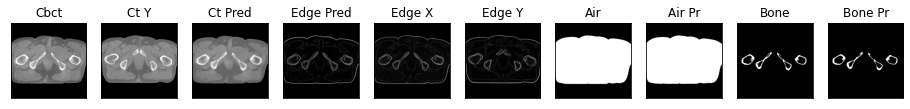

116it [00:51,  2.18it/s]

ssim score = 0.7598295211791992
psnr score = 20.93395233154297
snr score = 13.019834518432617
mae error = 0.04029640555381775
air dice score = 0.9964309717490577
bone dice score = 0.9352320963996271
contour dice score = 0.4120287299156189


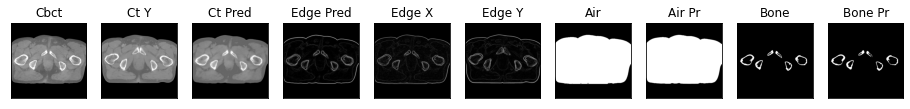

117it [00:51,  2.19it/s]

ssim score = 0.7602667212486267
psnr score = 21.00737762451172
snr score = 13.141938209533691
mae error = 0.04056406766176224
air dice score = 0.9957931577971468
bone dice score = 0.936797000536465
contour dice score = 0.38799476623535156


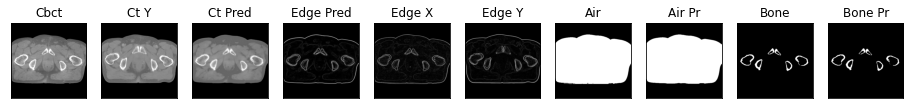

118it [00:52,  1.89it/s]

ssim score = 0.7536710500717163
psnr score = 20.794981002807617
snr score = 12.952155113220215
mae error = 0.04268971458077431
air dice score = 0.9959694232105653
bone dice score = 0.9313750974794467
contour dice score = 0.41854530572891235


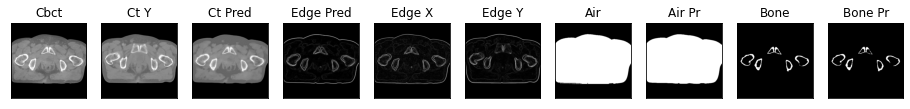

119it [00:53,  1.98it/s]

ssim score = 0.7404173612594604
psnr score = 20.731658935546875
snr score = 12.931610107421875
mae error = 0.04409561678767204
air dice score = 0.9968521310206623
bone dice score = 0.9150455552829962
contour dice score = 0.394546240568161


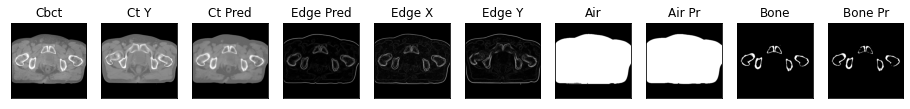

120it [00:53,  2.07it/s]

ssim score = 0.7397969961166382
psnr score = 20.63418960571289
snr score = 12.892477035522461
mae error = 0.04468502849340439
air dice score = 0.9967755308858096
bone dice score = 0.9043122084434597
contour dice score = 0.3860127031803131


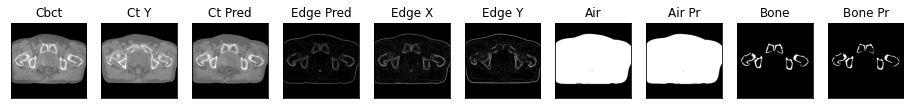

121it [00:53,  2.11it/s]

ssim score = 0.7355635762214661
psnr score = 20.581462860107422
snr score = 12.764378547668457
mae error = 0.04561968147754669
air dice score = 0.9973482735017185
bone dice score = 0.8700106723599784
contour dice score = 0.37847697734832764


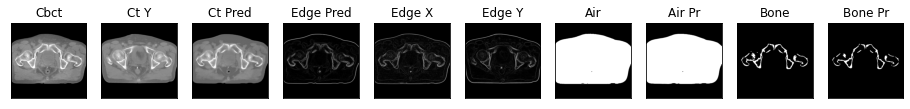

122it [00:54,  2.18it/s]

ssim score = 0.7357891201972961
psnr score = 20.535545349121094
snr score = 12.611242294311523
mae error = 0.045790888369083405
air dice score = 0.997302815078933
bone dice score = 0.8432501599504878
contour dice score = 0.3672161102294922


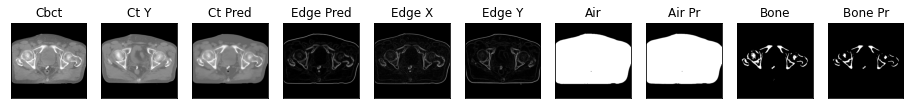

123it [00:54,  2.19it/s]

ssim score = 0.7477962970733643
psnr score = 20.856647491455078
snr score = 12.809261322021484
mae error = 0.04323707893490791
air dice score = 0.9975765181300635
bone dice score = 0.8039895923698612
contour dice score = 0.3654729127883911


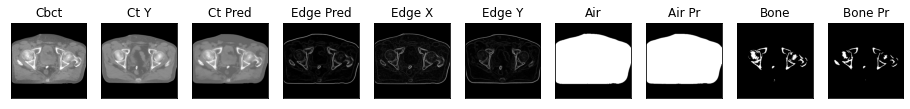

124it [00:55,  2.21it/s]

ssim score = 0.7539292573928833
psnr score = 21.087139129638672
snr score = 12.92732048034668
mae error = 0.040724921971559525
air dice score = 0.9978477499466277
bone dice score = 0.8699463131382715
contour dice score = 0.3671586811542511


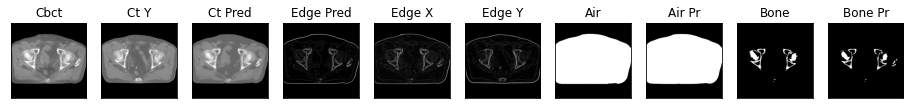

125it [00:55,  2.21it/s]

ssim score = 0.75115966796875
psnr score = 21.29745101928711
snr score = 13.086986541748047
mae error = 0.03783467784523964
air dice score = 0.997986670369343
bone dice score = 0.9194552939943054
contour dice score = 0.3603520095348358


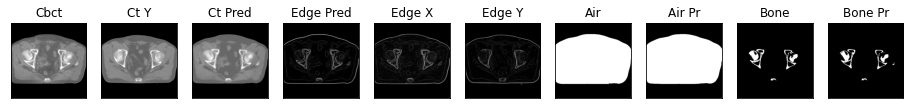

126it [00:56,  2.24it/s]

ssim score = 0.7506861090660095
psnr score = 21.096969604492188
snr score = 12.918659210205078
mae error = 0.039471983909606934
air dice score = 0.9981190785807181
bone dice score = 0.9190887666937594
contour dice score = 0.38325580954551697


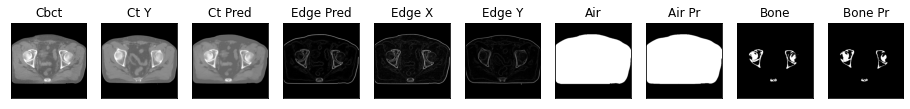

127it [00:56,  2.20it/s]

ssim score = 0.7489067316055298
psnr score = 20.832855224609375
snr score = 12.668023109436035
mae error = 0.04086410254240036
air dice score = 0.99805347693312
bone dice score = 0.9260419176111051
contour dice score = 0.4144060015678406


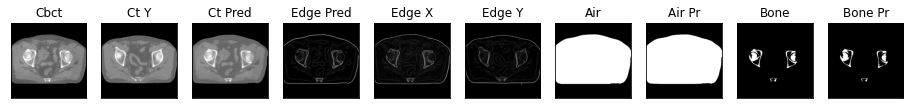

128it [00:57,  1.90it/s]

ssim score = 0.747804582118988
psnr score = 20.483051300048828
snr score = 12.176724433898926
mae error = 0.042380440980196
air dice score = 0.9979025076165937
bone dice score = 0.9375300336384246
contour dice score = 0.39603960514068604


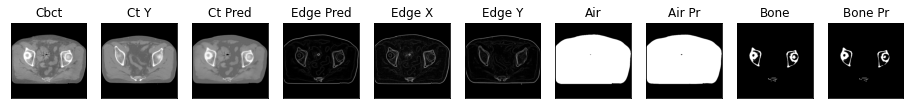

129it [00:57,  1.99it/s]

ssim score = 0.7573517560958862
psnr score = 20.602828979492188
snr score = 12.237195014953613
mae error = 0.04134140908718109
air dice score = 0.9977799631367897
bone dice score = 0.9431345353683338
contour dice score = 0.4094562530517578


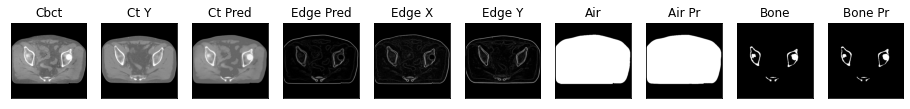

130it [00:58,  2.06it/s]

ssim score = 0.7528752088546753
psnr score = 20.952922821044922
snr score = 12.612936019897461
mae error = 0.03958117961883545
air dice score = 0.9977753322210008
bone dice score = 0.9299107955592588
contour dice score = 0.39867424964904785


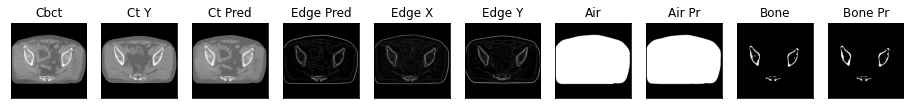

131it [00:58,  2.08it/s]

ssim score = 0.7478899955749512
psnr score = 20.79227066040039
snr score = 12.52509593963623
mae error = 0.04004879668354988
air dice score = 0.9974838951444545
bone dice score = 0.9404884760932148
contour dice score = 0.40625


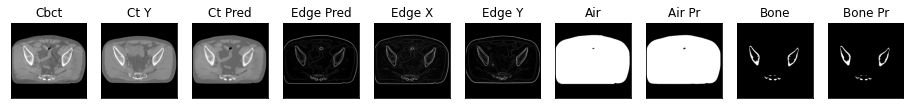

132it [00:59,  2.13it/s]

ssim score = 0.7409537434577942
psnr score = 20.41925048828125
snr score = 12.2813081741333
mae error = 0.0421583317220211
air dice score = 0.9974805053352259
bone dice score = 0.9366311024905168
contour dice score = 0.44423261284828186


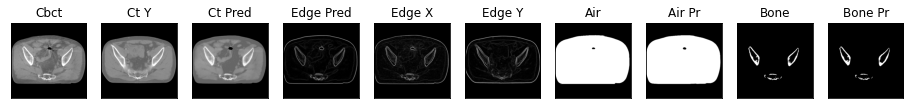

133it [00:59,  2.16it/s]

ssim score = 0.7374195456504822
psnr score = 20.25019645690918
snr score = 12.146211624145508
mae error = 0.043365612626075745
air dice score = 0.9974960273510873
bone dice score = 0.9280193968794057
contour dice score = 0.45489442348480225


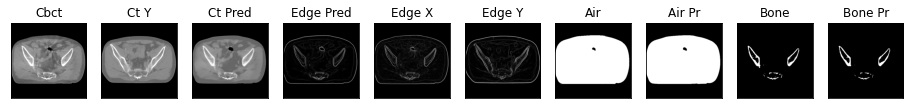

134it [01:00,  2.15it/s]

ssim score = 0.727159321308136
psnr score = 20.26507568359375
snr score = 12.131303787231445
mae error = 0.04401350021362305
air dice score = 0.9974527367989006
bone dice score = 0.9032340534334241
contour dice score = 0.37554165720939636


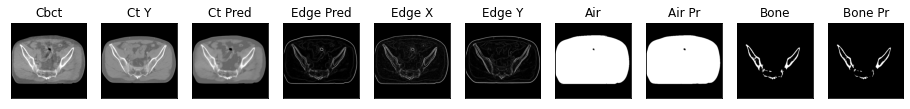

135it [01:00,  2.15it/s]

ssim score = 0.7254691123962402
psnr score = 20.557037353515625
snr score = 12.35988712310791
mae error = 0.042554814368486404
air dice score = 0.9975413608507149
bone dice score = 0.8798003604619464
contour dice score = 0.3982600271701813


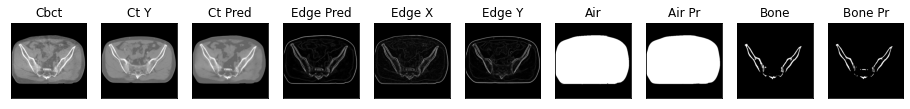

136it [01:00,  2.20it/s]

ssim score = 0.8454700708389282
psnr score = 23.174697875976562
snr score = 14.65208911895752
mae error = 0.027382420375943184
air dice score = 0.9974670004382628
bone dice score = 0.9156123326383048
contour dice score = 0.45047762989997864


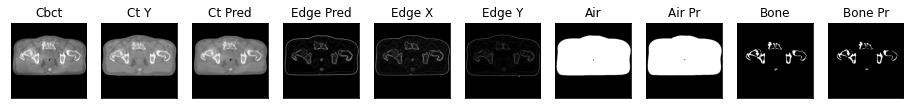

137it [01:01,  2.21it/s]

ssim score = 0.8473752737045288
psnr score = 23.1906681060791
snr score = 14.708070755004883
mae error = 0.02712651528418064
air dice score = 0.9971639757933073
bone dice score = 0.9084315503185024
contour dice score = 0.4238143265247345


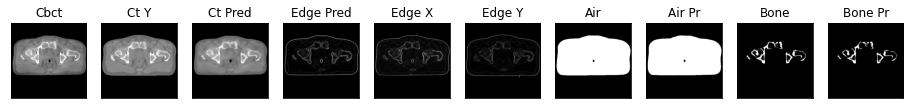

138it [01:02,  1.89it/s]

ssim score = 0.8483794927597046
psnr score = 23.378570556640625
snr score = 14.90376091003418
mae error = 0.02689359337091446
air dice score = 0.9974306077915907
bone dice score = 0.889432219507071
contour dice score = 0.39209726452827454


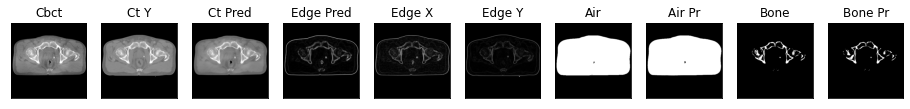

139it [01:02,  1.97it/s]

ssim score = 0.8526779413223267
psnr score = 23.393512725830078
snr score = 14.860282897949219
mae error = 0.025945212692022324
air dice score = 0.9974895397489558
bone dice score = 0.901062753037689
contour dice score = 0.3746192753314972


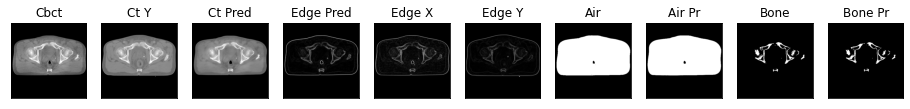

140it [01:03,  2.03it/s]

ssim score = 0.8590961694717407
psnr score = 23.571929931640625
snr score = 14.883075714111328
mae error = 0.02372666634619236
air dice score = 0.9976467414113573
bone dice score = 0.9102844638962759
contour dice score = 0.345389723777771


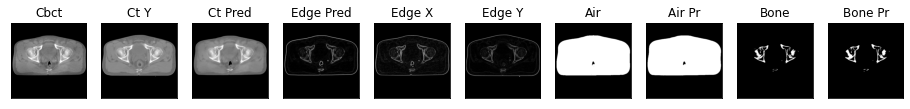

141it [01:03,  2.08it/s]

ssim score = 0.8619077205657959
psnr score = 23.68230628967285
snr score = 14.972648620605469
mae error = 0.02323896437883377
air dice score = 0.9974300399771578
bone dice score = 0.9248761695112152
contour dice score = 0.35089513659477234


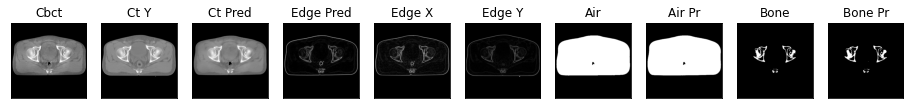

142it [01:03,  2.11it/s]

ssim score = 0.8579405546188354
psnr score = 23.610607147216797
snr score = 14.885318756103516
mae error = 0.023568574339151382
air dice score = 0.9975201815016111
bone dice score = 0.927622661968994
contour dice score = 0.40965092182159424


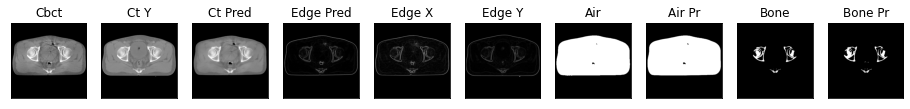

143it [01:04,  2.15it/s]

ssim score = 0.8510001301765442
psnr score = 23.0268497467041
snr score = 14.31092643737793
mae error = 0.025098320096731186
air dice score = 0.9973275999121838
bone dice score = 0.9199723566009679
contour dice score = 0.40164777636528015


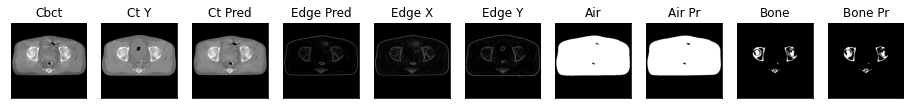

144it [01:04,  2.22it/s]

ssim score = 0.8457985520362854
psnr score = 23.055023193359375
snr score = 14.394880294799805
mae error = 0.02578994818031788
air dice score = 0.9971869858287798
bone dice score = 0.9340087623229189
contour dice score = 0.4155038893222809


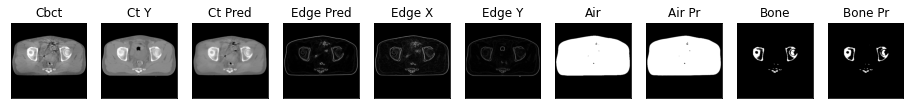

145it [01:05,  2.20it/s]

ssim score = 0.8435636758804321
psnr score = 22.739898681640625
snr score = 14.057827949523926
mae error = 0.026913892477750778
air dice score = 0.9970592268661742
bone dice score = 0.9309121861266717
contour dice score = 0.406022846698761


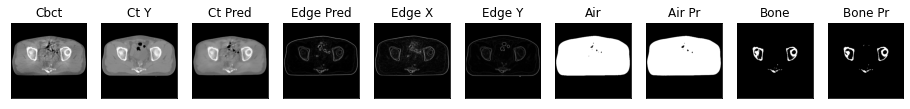

146it [01:05,  2.23it/s]

ssim score = 0.8453187942504883
psnr score = 22.204999923706055
snr score = 13.452156066894531
mae error = 0.027039486914873123
air dice score = 0.9969490514532173
bone dice score = 0.9199689199701636
contour dice score = 0.39416059851646423


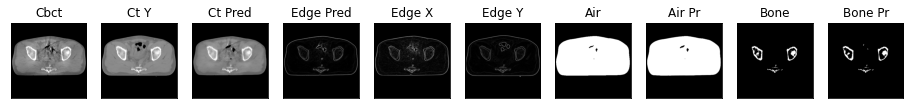

147it [01:06,  2.23it/s]

ssim score = 0.8461247682571411
psnr score = 22.43566131591797
snr score = 13.638921737670898
mae error = 0.02622349187731743
air dice score = 0.9973539308657102
bone dice score = 0.920991735538496
contour dice score = 0.3981142044067383


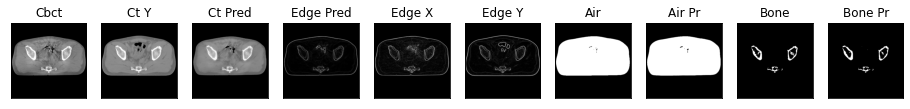

148it [01:06,  1.90it/s]

ssim score = 0.8471173048019409
psnr score = 22.634849548339844
snr score = 13.837013244628906
mae error = 0.025812316685914993
air dice score = 0.9972900145095561
bone dice score = 0.9410456062300803
contour dice score = 0.4069400727748871


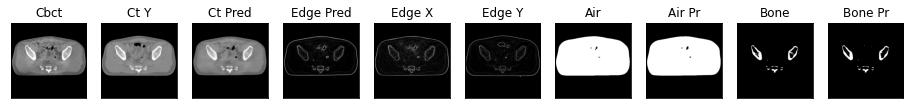

149it [01:07,  1.99it/s]

ssim score = 0.8429273962974548
psnr score = 22.62399673461914
snr score = 13.839519500732422
mae error = 0.026290511712431908
air dice score = 0.9968844949642974
bone dice score = 0.9408184999248316
contour dice score = 0.439641535282135


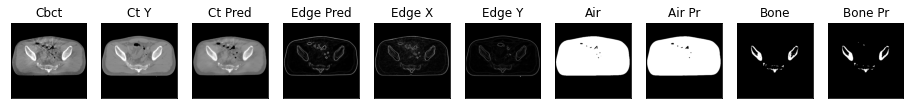

150it [01:07,  2.05it/s]

ssim score = 0.8424189686775208
psnr score = 22.53093719482422
snr score = 13.80166244506836
mae error = 0.02743917889893055
air dice score = 0.9970719010953282
bone dice score = 0.9364583333341607
contour dice score = 0.4458531439304352


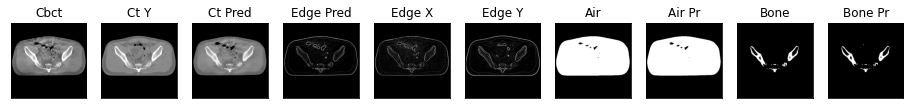

151it [01:08,  2.10it/s]

ssim score = 0.8424230217933655
psnr score = 22.094558715820312
snr score = 13.384655952453613
mae error = 0.028475748375058174
air dice score = 0.9967399403874839
bone dice score = 0.9148994018499877
contour dice score = 0.44467973709106445


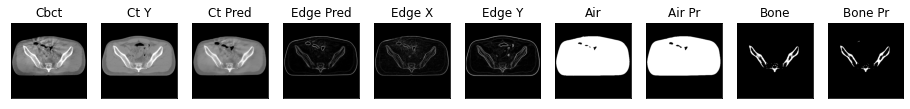

152it [01:08,  2.11it/s]

ssim score = 0.8447327613830566
psnr score = 22.282814025878906
snr score = 13.518172264099121
mae error = 0.02733335644006729
air dice score = 0.9964638004839037
bone dice score = 0.912145086964291
contour dice score = 0.3949044644832611


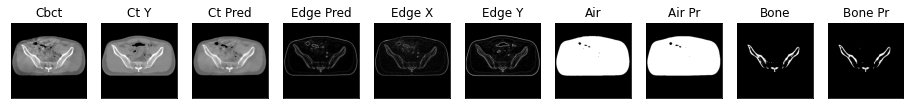

153it [01:09,  2.14it/s]

ssim score = 0.8483000993728638
psnr score = 22.579238891601562
snr score = 13.778242111206055
mae error = 0.026292867958545685
air dice score = 0.997024731915951
bone dice score = 0.8978558665887753
contour dice score = 0.3829333186149597


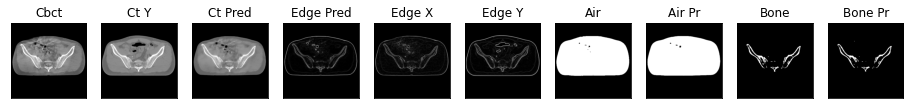

154it [01:09,  2.19it/s]

ssim score = 0.8519347310066223
psnr score = 22.75899887084961
snr score = 13.958073616027832
mae error = 0.025386245921254158
air dice score = 0.9968205223649135
bone dice score = 0.8937778377663143
contour dice score = 0.36402568221092224


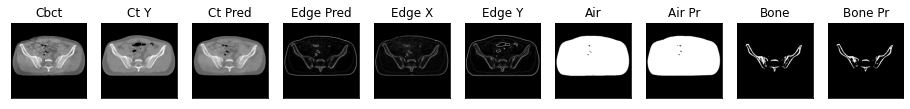

155it [01:10,  2.20it/s]

ssim score = 0.8503955602645874
psnr score = 22.90216827392578
snr score = 14.099824905395508
mae error = 0.0254044272005558
air dice score = 0.9971269276762302
bone dice score = 0.9086273983643013
contour dice score = 0.3832077383995056


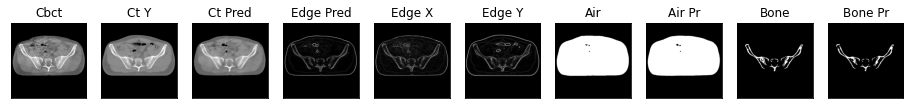

156it [01:10,  2.21it/s]

ssim score = 0.8403933644294739
psnr score = 22.295122146606445
snr score = 13.49781608581543
mae error = 0.026966208592057228
air dice score = 0.996603409055501
bone dice score = 0.8932171070567527
contour dice score = 0.37141311168670654


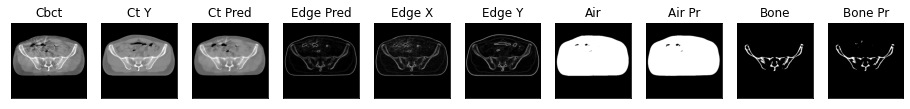

157it [01:10,  2.22it/s]

ssim score = 0.8358041048049927
psnr score = 21.77189826965332
snr score = 12.957319259643555
mae error = 0.028539393097162247
air dice score = 0.9958739479350198
bone dice score = 0.882609882611485
contour dice score = 0.39542484283447266


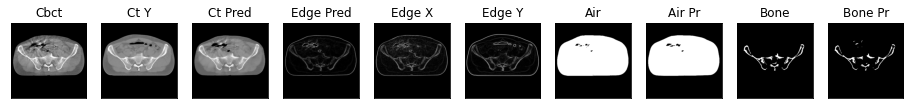

158it [01:11,  1.89it/s]

ssim score = 0.8321537375450134
psnr score = 21.522785186767578
snr score = 12.689580917358398
mae error = 0.02943429723381996
air dice score = 0.9964175727484159
bone dice score = 0.8680382649735547
contour dice score = 0.39187705516815186


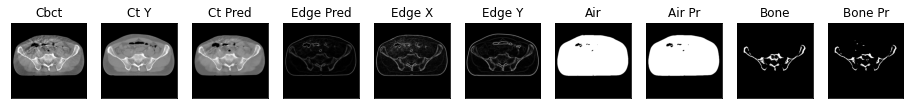

159it [01:12,  1.97it/s]

ssim score = 0.8234060406684875
psnr score = 21.158218383789062
snr score = 12.279073715209961
mae error = 0.03073102980852127
air dice score = 0.9956606125637135
bone dice score = 0.8634639696603861
contour dice score = 0.41721853613853455


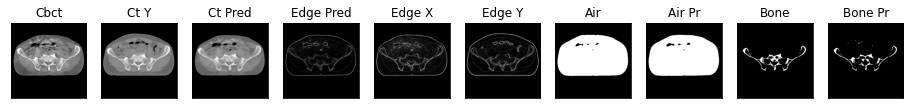

160it [01:12,  2.04it/s]

ssim score = 0.8174417018890381
psnr score = 21.12917709350586
snr score = 12.196239471435547
mae error = 0.03112787939608097
air dice score = 0.995364684441983
bone dice score = 0.8894502586323896
contour dice score = 0.378888875246048


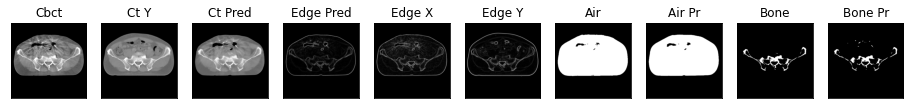

161it [01:12,  2.09it/s]

ssim score = 0.8108686208724976
psnr score = 20.783769607543945
snr score = 11.881294250488281
mae error = 0.03316328674554825
air dice score = 0.9952884248058105
bone dice score = 0.8980611395277974
contour dice score = 0.40445682406425476


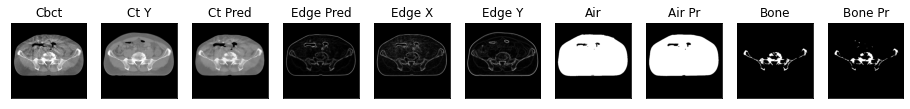

162it [01:13,  2.14it/s]

ssim score = 0.8046824932098389
psnr score = 20.551437377929688
snr score = 11.59373664855957
mae error = 0.03359012305736542
air dice score = 0.9956145246942163
bone dice score = 0.8978282329726329
contour dice score = 0.4066852331161499


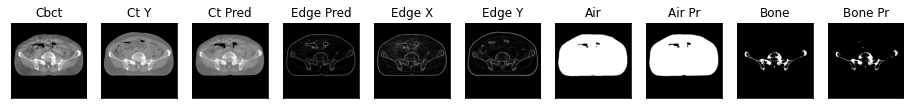

163it [01:13,  2.17it/s]

ssim score = 0.8126012086868286
psnr score = 21.193561553955078
snr score = 12.088327407836914
mae error = 0.031126942485570908
air dice score = 0.9958823435529982
bone dice score = 0.9147167881356001
contour dice score = 0.3008948564529419


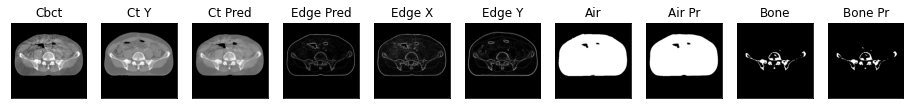

164it [01:14,  2.20it/s]

ssim score = 0.8672611117362976
psnr score = 24.892383575439453
snr score = 15.273295402526855
mae error = 0.023812999948859215
air dice score = 0.9958196697095957
bone dice score = 0.9059356136844584
contour dice score = 0.39398351311683655


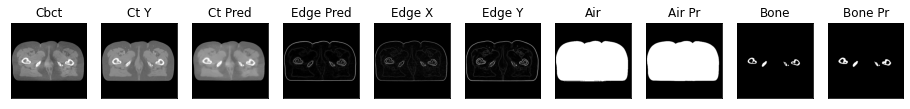

165it [01:14,  2.18it/s]

ssim score = 0.8686028718948364
psnr score = 25.240055084228516
snr score = 15.741978645324707
mae error = 0.02222617343068123
air dice score = 0.9958555531919606
bone dice score = 0.9126338329783162
contour dice score = 0.3770410716533661


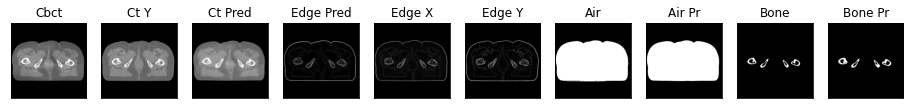

166it [01:15,  2.18it/s]

ssim score = 0.8657626509666443
psnr score = 25.361059188842773
snr score = 15.945900917053223
mae error = 0.02144327200949192
air dice score = 0.9960785457089989
bone dice score = 0.917202415742895
contour dice score = 0.3869076669216156


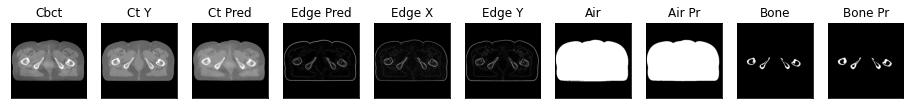

167it [01:15,  2.19it/s]

ssim score = 0.861906886100769
psnr score = 25.336307525634766
snr score = 15.984596252441406
mae error = 0.021445509046316147
air dice score = 0.9960026407237353
bone dice score = 0.9231038710820966
contour dice score = 0.3869076669216156


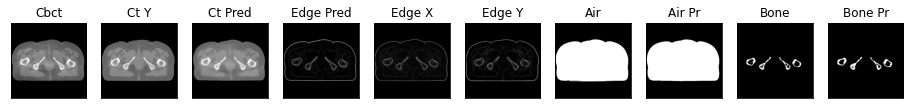

168it [01:16,  1.90it/s]

ssim score = 0.8610631227493286
psnr score = 25.21585464477539
snr score = 15.892601013183594
mae error = 0.021502817049622536
air dice score = 0.9961981033884612
bone dice score = 0.9380590717310032
contour dice score = 0.39842596650123596


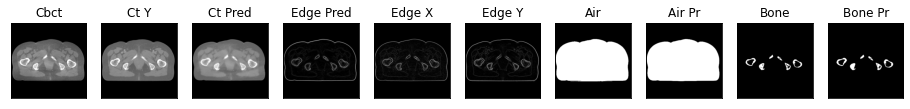

169it [01:16,  1.97it/s]

ssim score = 0.8627861142158508
psnr score = 25.134014129638672
snr score = 15.833717346191406
mae error = 0.02145399898290634
air dice score = 0.9958971770559211
bone dice score = 0.9287709497219139
contour dice score = 0.3731125295162201


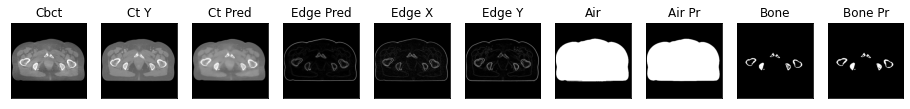

170it [01:17,  2.06it/s]

ssim score = 0.8608324527740479
psnr score = 25.074485778808594
snr score = 15.805517196655273
mae error = 0.021477941423654556
air dice score = 0.9957482932023081
bone dice score = 0.9340013821711471
contour dice score = 0.38588008284568787


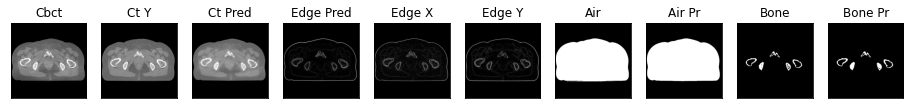

171it [01:17,  2.10it/s]

ssim score = 0.8597040176391602
psnr score = 24.830636978149414
snr score = 15.610032081604004
mae error = 0.02192276157438755
air dice score = 0.9957825915148932
bone dice score = 0.9276638997132363
contour dice score = 0.38758230209350586


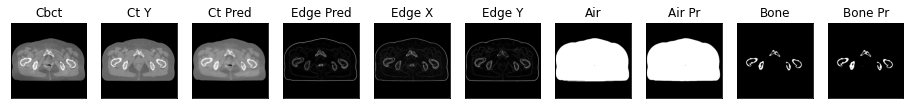

172it [01:18,  2.14it/s]

ssim score = 0.8595242500305176
psnr score = 24.567384719848633
snr score = 15.389522552490234
mae error = 0.02190677635371685
air dice score = 0.9957871428776864
bone dice score = 0.9353856020533047
contour dice score = 0.37614238262176514


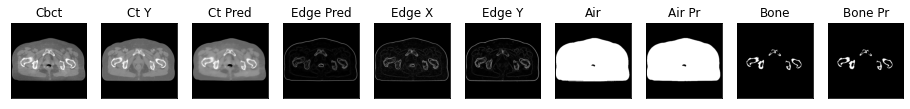

173it [01:18,  2.14it/s]

ssim score = 0.8564863204956055
psnr score = 24.4776611328125
snr score = 15.387500762939453
mae error = 0.02200712263584137
air dice score = 0.995571403922474
bone dice score = 0.9367268590937476
contour dice score = 0.3870967626571655


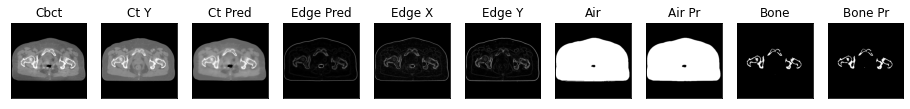

174it [01:19,  2.18it/s]

ssim score = 0.8603781461715698
psnr score = 25.512569427490234
snr score = 16.535680770874023
mae error = 0.019958266988396645
air dice score = 0.9953132937885076
bone dice score = 0.9218846106541778
contour dice score = 0.4247460663318634


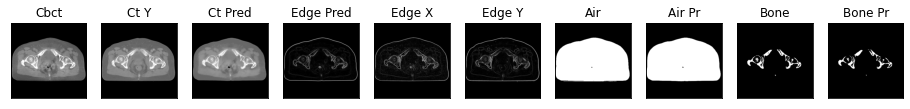

175it [01:19,  2.18it/s]

ssim score = 0.8608708381652832
psnr score = 24.70599937438965
snr score = 15.60055923461914
mae error = 0.02118873782455921
air dice score = 0.9952026847755192
bone dice score = 0.9233517375783801
contour dice score = 0.37447988986968994


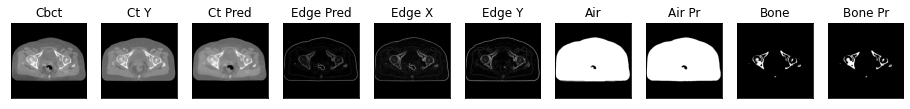

176it [01:19,  2.21it/s]

ssim score = 0.8633105754852295
psnr score = 24.70877456665039
snr score = 15.493912696838379
mae error = 0.02165299654006958
air dice score = 0.9955017548886215
bone dice score = 0.899694957834206
contour dice score = 0.4164332449436188


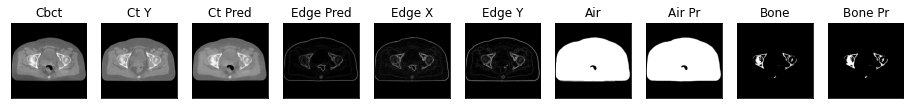

177it [01:20,  2.21it/s]

ssim score = 0.8666767477989197
psnr score = 24.75579261779785
snr score = 15.513806343078613
mae error = 0.021860476583242416
air dice score = 0.9956664215493823
bone dice score = 0.9226258348277794
contour dice score = 0.4355800151824951


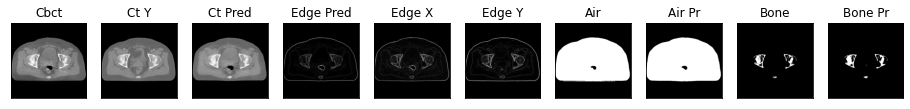

178it [01:21,  1.89it/s]

ssim score = 0.8701140284538269
psnr score = 25.3798770904541
snr score = 16.129884719848633
mae error = 0.02145933173596859
air dice score = 0.9960080405424563
bone dice score = 0.9326691306454657
contour dice score = 0.42149531841278076


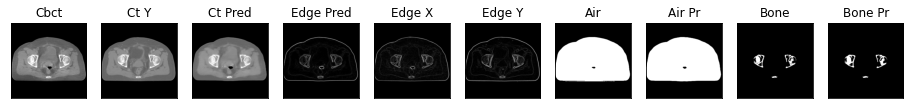

179it [01:21,  1.97it/s]

ssim score = 0.8710196614265442
psnr score = 26.190603256225586
snr score = 16.97484016418457
mae error = 0.019902924075722694
air dice score = 0.9963943993939249
bone dice score = 0.9394172961316569
contour dice score = 0.4764595031738281


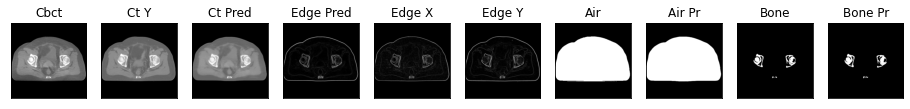

180it [01:22,  2.04it/s]

ssim score = 0.8667556047439575
psnr score = 25.766616821289062
snr score = 16.60234260559082
mae error = 0.020720988512039185
air dice score = 0.9969650563831289
bone dice score = 0.949586389886849
contour dice score = 0.4843524396419525


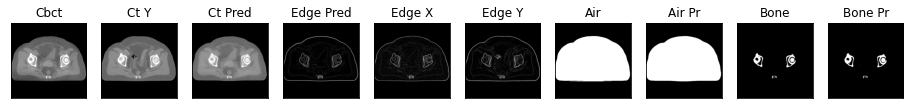

181it [01:22,  2.08it/s]

ssim score = 0.8552326560020447
psnr score = 24.942150115966797
snr score = 15.815437316894531
mae error = 0.022222811356186867
air dice score = 0.9971489517392794
bone dice score = 0.9435483870977226
contour dice score = 0.5055582523345947


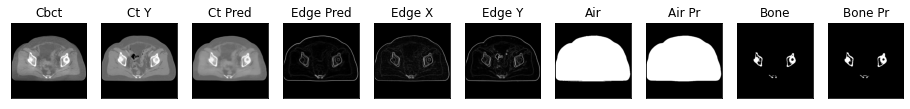

182it [01:22,  2.15it/s]

ssim score = 0.8367437720298767
psnr score = 23.160436630249023
snr score = 13.961286544799805
mae error = 0.026373084634542465
air dice score = 0.9971436204097589
bone dice score = 0.9121287128730996
contour dice score = 0.4794520437717438


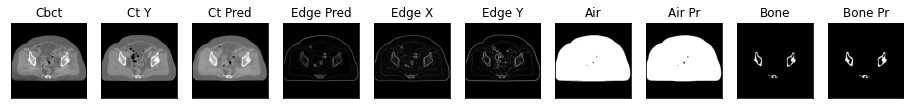

183it [01:23,  2.17it/s]

ssim score = 0.8262689709663391
psnr score = 22.71121597290039
snr score = 13.494071006774902
mae error = 0.028506994247436523
air dice score = 0.9968652464870338
bone dice score = 0.9283919598004943
contour dice score = 0.47826087474823


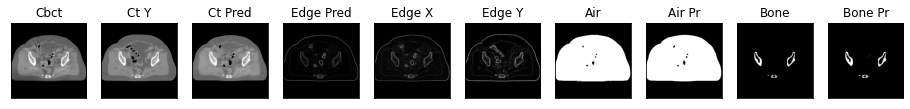

184it [01:23,  2.21it/s]

ssim score = 0.8232871890068054
psnr score = 23.355079650878906
snr score = 14.202850341796875
mae error = 0.027706557884812355
air dice score = 0.9972159117720437
bone dice score = 0.9247528747241325
contour dice score = 0.4755313992500305


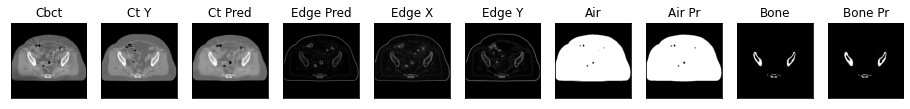

185it [01:24,  2.21it/s]

ssim score = 0.8269945979118347
psnr score = 23.60680389404297
snr score = 14.50966739654541
mae error = 0.026995792984962463
air dice score = 0.9968732044309654
bone dice score = 0.940742043257592
contour dice score = 0.47310757637023926


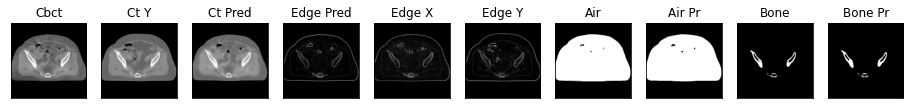

186it [01:24,  2.22it/s]

ssim score = 0.821690559387207
psnr score = 22.951396942138672
snr score = 13.91869068145752
mae error = 0.02847968228161335
air dice score = 0.9970026400587582
bone dice score = 0.9363207547179198
contour dice score = 0.4375614523887634


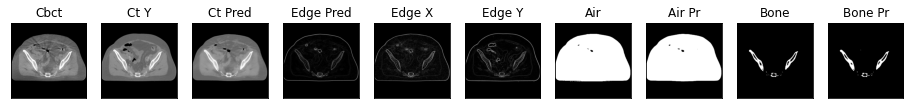

187it [01:25,  2.22it/s]

ssim score = 0.8186531066894531
psnr score = 22.80390739440918
snr score = 13.844059944152832
mae error = 0.029014846310019493
air dice score = 0.9967167472158038
bone dice score = 0.927354504566889
contour dice score = 0.40848544239997864


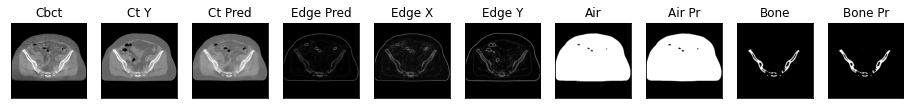

188it [01:25,  1.88it/s]

ssim score = 0.8211857080459595
psnr score = 22.743408203125
snr score = 13.77927303314209
mae error = 0.029296858236193657
air dice score = 0.9965159971086055
bone dice score = 0.9003276897883625
contour dice score = 0.4203323423862457


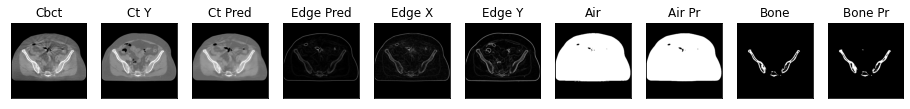

189it [01:26,  1.97it/s]

ssim score = 0.8204816579818726
psnr score = 22.780902862548828
snr score = 13.794588088989258
mae error = 0.029569679871201515
air dice score = 0.9968785471055639
bone dice score = 0.9147636749878549
contour dice score = 0.39242351055145264


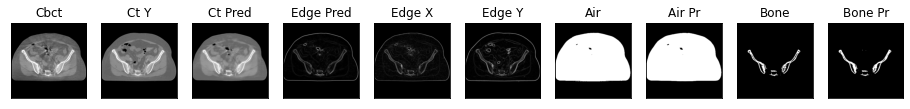

190it [01:26,  2.05it/s]

ssim score = 0.8253083229064941
psnr score = 23.44073486328125
snr score = 14.466056823730469
mae error = 0.02824614755809307
air dice score = 0.9972070431086842
bone dice score = 0.9154929577476457
contour dice score = 0.4025096595287323


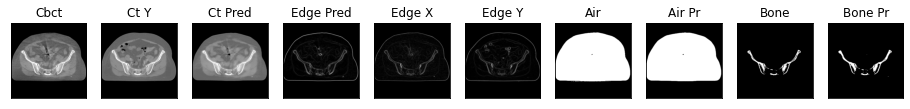

191it [01:27,  2.18it/s]


In [44]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [45]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)
tf_discriminator.load_state_dict(checkpoint["tf_discriminator"])

<All keys matched successfully>

In [46]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)

In [47]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
#             score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test
eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

191it [00:18, 10.28it/s]


(0.8428221120260149,
 23.542038183561793,
 14.546310125221133,
 0.026399120805463243,
 0.9968412479282929,
 0.9169532929521288,
 0.4626665917366587,
 0.49109947643979057)

In [48]:
# import torchvision.models as models
# models.vgg16(pretrained=True)